# Intoduction

This analysis examines targeted receiver separation and quarterback separation before the throw using NFL tracking data. 
Features are enginnered such as separation from the nearest defender, TR direction in the final pre-throw frame, and QB proximity to defenders. 
The goal is place separation in the context of route type, pass length, QB timing.

Overview : 
- the TR’s separation from the nearest defender at every pre-throw moment.
- the QB’s separation from the nearest defender at every pre-throw moment(pressure proxy).
- timing elements such as time to throw and how separation evolves leading up to the release.
- EDA - differences in separation across targeted routes and other play parameteres.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings('ignore')

# Configuration
SUPPLEMENT_FILE = 'supplementary_data.csv'
INPUT_PATTERN = 'input_2023_w{:02d}.csv'
OUTPUT_PATTERN = 'supplement-input_2023_w{:02d}.csv'
NUM_WEEKS = 18


# Updated paths for Kaggle competition data
# KAGGLE_PATH = "/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final"
# TRAIN_PATH = os.path.join(KAGGLE_PATH, "train")

KAGGLE_PATH = "data"
TRAIN_PATH = os.path.join(KAGGLE_PATH, "input")


# Data Loading and Preparation

In [2]:
 # Concatenate all weekly data into one dataset
print(f"\n{'='*70}")
print("STEP 1: CONCATENATING ALL WEEKS INTO SINGLE DATASET")
print("="*70)

# Load all weeks data into one dataframe
input_data_frames = []
for week in range(1, NUM_WEEKS + 1):
    #file_path = os.path.join(TRAIN_PATH, INPUT_PATTERN.format(week))
    file_path = os.path.join('data', 'input', INPUT_PATTERN.format(week))
    df_week = pd.read_csv(file_path)
    df_week['week'] = week  # Add week column to track the source
    input_data_frames.append(df_week)

# Combine all dataframes
input_data = pd.concat(input_data_frames, ignore_index=True)
print(f"Loaded {len(input_data_frames)} weeks of data with {len(input_data)} total rows")
print(f"Test : {input_data['week'].max()}")


STEP 1: CONCATENATING ALL WEEKS INTO SINGLE DATASET
Loaded 18 weeks of data with 4880579 total rows
Test : 18


In [3]:
# Load supplementary data
supplementary_data = pd.read_csv(os.path.join(KAGGLE_PATH, SUPPLEMENT_FILE))
supplementary_data.columns

# Add feature pass_category based on pass_length. 
# pass_categories are 'short', 'intermediate', and 'long'. Short is <=5 yards, intermediate is >5 and <=15 yards, long is >15 yards. Use dict mapping.
conditions = [
    supplementary_data['pass_length'] < 5,
    (supplementary_data['pass_length'] >= 5) & (supplementary_data['pass_length'] <= 15),
    supplementary_data['pass_length'] > 15
]

categories = ['short', 'intermediate', 'long']

supplementary_data['pass_type'] = np.select(
    conditions, 
    categories, 
    default='unknown'
)

# Merge the supplementary column 'route_of_targeted_receiver' into the input data
input_data = pd.merge(
    input_data,                 # The left DataFrame (the one receiving the new column)
    supplementary_data[['game_id', 'play_id', 'route_of_targeted_receiver']],  # The right DataFrame (only the key columns and the column to add)
    on=['game_id', 'play_id'],  # The key columns to match on
    how='left'           # Specifies a left join
)


# Feature Enginnering 
## Target Reciever and QB - Frame-Level Separation and Play-level aggregation 
Compute defender proximity for both targeted receivers and quarterbacks.
Summarize separation metrics at the play level.


In [4]:
def calculate_euclidean_distance_vectorized(tr_x, tr_y, def_x, def_y):
    """
    Calculate Euclidean distance between Targeted Receiver and all defenders using vectorized operations.
    
    Parameters:
    tr_x, tr_y: Quaterback coordinates (scalar)
    def_x, def_y: Defender coordinates (arrays/series)
    
    Returns:
    Array: Euclidean distances to all defenders
    """
    return np.sqrt((def_x - tr_x)**2 + (def_y - tr_y)**2)

def calculate_frame_level_separation(df):
    """
    Calculate minimum separation between Targeted Receiver and defensive players at FRAME level.
    Returns only Targeted Receiver data with tr_min_separation per frame.
    
    Parameters:
    df: DataFrame containing tracking data with columns:
        - game_id, play_id, frame_id, nfl_id
        - player_role: 'Targeted Receiver' or 'Defensive Coverage'
        - player_name
        - x, y: Player coordinates
    
    Returns:
    DataFrame: Targeted Receiver data with columns (game_id, play_id, nfl_id, frame_id, player_name, player_role, tr_min_separation)
    """
    
    # Group by game, play, and frame (FRAME-LEVEL calculation)
    grouped = df.groupby(['game_id', 'play_id', 'frame_id'])
    
    # List to store Targeted Receiver results
    tr_results = []
    
    for (game_id, play_id, frame_id), frame_group in grouped:
        # Identify Targeted Receivers and defenders in this specific frame
        target_receivers = frame_group[frame_group['player_role'] == 'Targeted Receiver']
        defenders = frame_group[frame_group['player_role'] == 'Defensive Coverage']
        
        # Skip if no Targeted Receivers or defenders in this frame
        if target_receivers.empty or defenders.empty:
            continue
        
        # Extract defender coordinates as arrays for vectorized calculation
        def_x = defenders['x'].values
        def_y = defenders['y'].values
        
        # For each Targeted Receiver, calculate distance to all defenders using vectorization
        for tr_idx, tr_row in target_receivers.iterrows():
            tr_x, tr_y = tr_row['x'], tr_row['y']
            
            # Vectorized distance calculation across all defenders in this frame
            distances = calculate_euclidean_distance_vectorized(tr_x, tr_y, def_x, def_y)
            
            # Find minimum distance for this frame
            min_distance = np.min(distances)
            
            # Create result record for this Targeted Receiver
            tr_result = {
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': tr_row['nfl_id'],
                'frame_id': frame_id,
                'player_name': tr_row['player_name'],
                'player_role': tr_row['player_role'],
                'player_position': tr_row['player_position'],
                'tr_min_separation': min_distance,
                'route_of_targeted_receiver': tr_row['route_of_targeted_receiver'],
                'dir': tr_row['dir']
            }
            tr_results.append(tr_result)
    
    # Convert results to DataFrame
    result_df = pd.DataFrame(tr_results)
    
    # Sort by game, play, receiver, and frame for chronological analysis
    if not result_df.empty:
        result_df = result_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)
    
    return result_df

def tr_calculate_play_level_aggregates(df):
    """
    Calculate play-level aggregate statistics for each Targeted Receiver.
    Aggregates: min, avg (mean), variance of separation across all frames in a play.
    
    Parameters:
    df: DataFrame with frame-level tr_min_separation calculated
    
    Returns:
    DataFrame: Play-level aggregates for each Targeted Receiver
    """
    
    # Filter for Targeted Receivers only
    tr_data = df[df['player_role'] == 'Targeted Receiver'].copy()
    
    # Remove rows where separation couldn't be calculated
    tr_data = tr_data[tr_data['tr_min_separation'].notna()]
    
    if tr_data.empty:
        return pd.DataFrame()
    
    # Group by game, play, and receiver (nflId)
    # Calculate aggregate statistics across all frames in each play
    play_aggregates = tr_data.groupby(['game_id', 'play_id']).agg({
        'tr_min_separation': [
            ('tr_play_min_separation', 'min'),      # Minimum separation across all frames
            ('tr_play_avg_separation', 'mean'),     # Average separation across all frames
            ('tr_play_var_separation', 'var')       # Variance of separation across all frames
        ],
        'player_name': 'first',                     # Keep receiver name
        'player_role': 'first',                     # Keep receiver role
        'player_position': 'first',                 # Keep receiver position
        'route_of_targeted_receiver': 'first',     # Keep receiver route
        'nfl_id': 'first',                          # Keep receiver nfl_id
        'frame_id': [
            ('nums_frame_pre_throw', 'count')],              # Keep pre-throw frames
    }).reset_index()
    
    # Flatten column names
    play_aggregates.columns = ['game_id', 'play_id',
                                'tr_play_min_separation', 
                                'tr_play_avg_separation', 
                                'tr_play_var_separation',
                                'player_name','player_role', 'player_position', 'route_of_targeted_receiver', 
                                'nfl_id',
                                'nums_frame_pre_throw'
                            ]
    
    # filter tr_data to get rows for 1st frame and last frame of each play for each receiver
    first_frames = tr_data.sort_values('frame_id').groupby(['game_id', 'play_id', 'nfl_id']).first().reset_index()
    last_frames = tr_data.sort_values('frame_id').groupby(['game_id', 'play_id', 'nfl_id']).last().reset_index()

    # Rename the 'direction' column in last_frames before merging
    last_frames = last_frames.rename(columns={'dir': 'tr_last_dir'})
    
    print("TR data column at play level:", last_frames.columns)

    # Merge first and last frame data to get initial and final separation
    first_last = pd.merge(
        first_frames[['game_id', 'play_id', 'nfl_id', 'tr_min_separation']],
        last_frames[['game_id', 'play_id', 'nfl_id', 'tr_min_separation', 'tr_last_dir']],
        on=['game_id', 'play_id', 'nfl_id'],
        suffixes=('_first', '_last')
    )
    
    # merge to play_aggregates
    play_aggregates = pd.merge(
        play_aggregates,
        first_last,
        on=['game_id', 'play_id', 'nfl_id'],
        how='left'
    )
    
    return play_aggregates

def calculate_frame_level_separation_qb(df):
    """
    Calculate minimum separation between Quarterback and defensive players at FRAME level.
    Returns only Quarterback data with qb_min_separation per frame.
    
    Parameters:
    df: DataFrame containing tracking data with columns:
        - game_id, play_id, frame_id, nfl_id
        - player_role: 'Passer' or 'Defensive Coverage'
        - player_name
        - x, y: Player coordinates
    
    Returns:
    DataFrame: Quarterback data with columns (game_id, play_id, nfl_id, frame_id, player_name, player_role, qb_min_separation)
    """
    
    # Group by game, play, and frame (FRAME-LEVEL calculation)
    grouped = df.groupby(['game_id', 'play_id', 'frame_id'])
    
    # List to store Quarterback results
    qb_results = []
    
    for (game_id, play_id, frame_id), frame_group in grouped:
        # Identify Quarterbacks and defenders in this specific frame
        quarterbacks = frame_group[frame_group['player_role'] == 'Passer']
        defenders = frame_group[frame_group['player_role'] == 'Defensive Coverage']
        
        # Skip if no Quarterbacks or defenders in this frame
        if quarterbacks.empty or defenders.empty:
            continue
        
        # Extract defender coordinates as arrays for vectorized calculation
        def_x = defenders['x'].values
        def_y = defenders['y'].values
        
        # For Quarterback, calculate distance to all defenders using vectorization
        for qb_idx, qb_row in quarterbacks.iterrows():
            qb_x, qb_y = qb_row['x'], qb_row['y']
            
            # Vectorized distance calculation across all defenders in this frame
            distances = calculate_euclidean_distance_vectorized(qb_x, qb_y, def_x, def_y)
            
            # Find minimum distance for this frame
            min_distance = np.min(distances)
            
            # Create result record for this Quarterback
            qb_result = {
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': qb_row['nfl_id'],
                'frame_id': frame_id,
                'player_name': qb_row['player_name'],
                'player_role': qb_row['player_role'],
                'player_position': qb_row['player_position'],
                'qb_min_separation': min_distance
            }
            qb_results.append(qb_result)
    
    # Convert results to DataFrame
    result_df = pd.DataFrame(qb_results)
    
    # Sort by game, play, quarterback, and frame for chronological analysis
    if not result_df.empty:
        result_df = result_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)
    
    return result_df


def qb_calculate_play_level_aggregates(df):
    """
    Calculate play-level aggregate statistics for each QB.
    Aggregates: min, avg (mean), variance of separation across all frames in a play.
    
    Parameters:
    df: DataFrame with frame-level qb_min_separation calculated
    
    Returns:
    DataFrame: Play-level aggregates for each QB
    """
    
    # Filter for QB only
    qb_data = df[df['player_role'] == 'Passer'].copy()
    
    # Remove rows where separation couldn't be calculated
    qb_data = qb_data[qb_data['qb_min_separation'].notna()]
    
    if qb_data.empty:
        return pd.DataFrame()
    
    # Group by game, play, and QB (nflId)
    # Calculate aggregate statistics across all frames in each play
    play_aggregates = qb_data.groupby(['game_id', 'play_id']).agg({
        'qb_min_separation': [
            ('qb_play_min_separation', 'min'),      # Minimum separation across all frames
            ('qb_play_avg_separation', 'mean'),     # Average separation across all frames
            ('qb_play_var_separation', 'var')       # Variance of separation across all frames
        ],
        'player_name': 'first',                     # Keep QB name
        'nfl_id': 'first',                          # Keep QB nfl_id
        'player_role': 'first',                      # Keep QB role
        'frame_id': [
            ('time_to_throw', lambda x: x.count() * 0.1)],              # Calculate time (0.1s per frame)
    }).reset_index()
    
    # Flatten column names
    play_aggregates.columns = ['game_id', 'play_id',
                                'qb_play_min_separation', 
                                'qb_play_avg_separation', 
                                'qb_play_var_separation',
                                'player_name', 'nfl_id', 'player_role',
                                'time_to_throw']
    
    # Calculate time to throw (0.1 seconds per frame)
    # play_aggregates['time_to_throw'] = play_aggregates['nums_frame_pre_throw'] * 0.1
    
    return play_aggregates


In [5]:
# Calculate frame-level minimum separation
print(f"\n{'='*70}")
print("STEP 2: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS")
print("="*70)
print("Processing all frames using vectorized distance calculations...")
tr_separation_df = calculate_frame_level_separation(input_data)
print("✓ Frame-level separation calculations complete")
print(f"✓ Returned {len(tr_separation_df)} Targeted Receiver records with separation data")
print(f"✓ Columns: {list(tr_separation_df.columns)}")


STEP 2: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS
Processing all frames using vectorized distance calculations...
✓ Frame-level separation calculations complete
✓ Returned 396879 Targeted Receiver records with separation data
✓ Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name', 'player_role', 'player_position', 'tr_min_separation', 'route_of_targeted_receiver', 'dir']


In [6]:
# Calculate play-level aggregates
tr_play_level_agg = pd.DataFrame()

print(f"\n{'='*70}")
print("STEP 3: CALCULATING PLAY-LEVEL AGGREGATE STATISTICS")
print("="*70)
print("Aggregating: min, avg, variance across all frames per play...")
tr_play_level_agg = tr_calculate_play_level_aggregates(tr_separation_df)
print(f"✓ Play-level aggregates created: {len(tr_play_level_agg):,} rows")
print(f"  • Unique plays with target receivers: {len(tr_play_level_agg):,}")


STEP 3: CALCULATING PLAY-LEVEL AGGREGATE STATISTICS
Aggregating: min, avg, variance across all frames per play...
TR data column at play level: Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name',
       'player_role', 'player_position', 'tr_min_separation',
       'route_of_targeted_receiver', 'tr_last_dir'],
      dtype='object')
✓ Play-level aggregates created: 14,107 rows
  • Unique plays with target receivers: 14,107


In [7]:
# Calculate frame-level minimum separation for Quarterbacks
print(f"\n{'='*70}")
print("STEP 5: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS FOR QUARTERBACKS")
print("="*70)
print("Processing all frames using vectorized distance calculations...")
qb_separation_df = calculate_frame_level_separation_qb(input_data)
print("✓ Frame-level separation calculations complete")
print(f"✓ Returned {len(qb_separation_df)} Quarterback records with separation data")
print(f"✓ Columns: {list(qb_separation_df.columns)}")


STEP 5: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS FOR QUARTERBACKS
Processing all frames using vectorized distance calculations...
✓ Frame-level separation calculations complete
✓ Returned 396765 Quarterback records with separation data
✓ Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name', 'player_role', 'player_position', 'qb_min_separation']


In [8]:
# Calculate play-level aggregates for Quarterbacks
qb_play_level_agg = pd.DataFrame()

print(f"\n{'='*70}")
print("STEP : CALCULATING QB PLAY-LEVEL AGGREGATE STATISTICS")
print("="*70)
print("Aggregating: min, avg, variance across all frames per play...")
qb_play_level_agg = qb_calculate_play_level_aggregates(qb_separation_df)
print(f"✓ Play-level aggregates created: {len(qb_play_level_agg):,} rows")
print(f"  • Unique plays with QBs: {len(qb_play_level_agg):,}")

print(qb_play_level_agg.head())


STEP : CALCULATING QB PLAY-LEVEL AGGREGATE STATISTICS
Aggregating: min, avg, variance across all frames per play...
✓ Play-level aggregates created: 14,105 rows
  • Unique plays with QBs: 14,105
      game_id  play_id  qb_play_min_separation  qb_play_avg_separation  \
0  2023090700      101                7.592635               10.694500   
1  2023090700      194                6.044047                7.292464   
2  2023090700      219                9.212394               10.028874   
3  2023090700      361                6.772215               13.231842   
4  2023090700      436                7.754902                8.062030   

   qb_play_var_separation      player_name  nfl_id player_role  time_to_throw  
0                7.928044       Jared Goff   43290      Passer            2.6  
1                0.921608  Patrick Mahomes   44822      Passer            3.2  
2                0.694733  Patrick Mahomes   44822      Passer            1.7  
3               16.627406       Jared G

In [9]:
# Merge play-level QB and Tr aggregates with supplementary data for pair analysis
play_columns = [
    "pass_result",
    "pass_length",
    "pass_location_type",
    "dropback_type",
    "dropback_distance",
    "play_action",
    "offense_formation",
    "defenders_in_the_box",
    "team_coverage_man_zone",
    "team_coverage_type",
    "pass_type"
]            
 
print(f"\n{'='*70}")
print("STEP : MERGING PLAY-LEVEL QB and TR AGGREGATES WITH SUPPLEMENTARY DATA")
print("="*70)       

# Merge play-level QB aggregates with TR aggregates at play level
play_level_qb_tr = pd.merge(qb_play_level_agg, tr_play_level_agg, on=['game_id', 'play_id'], how='left', suffixes=('_qb', '_tr'))

# Print columns after merging QB and TR aggregates
print("Columns after merging QB and TR play-level aggregates:")
#print(play_level_qb_tr.columns.tolist())    

# Merge play-level QB, Tr aggregates with supplementary data
play_columns = ['game_id', 'play_id'] + play_columns
qb_supplementary_data = supplementary_data[play_columns]
merged_data = pd.merge(play_level_qb_tr, qb_supplementary_data, on=['game_id', 'play_id'], how='left')

print(merged_data.columns.tolist())

# Output merged data info

print(f"✓ Merged play-level QB aggregates with supplementary data: {len(merged_data):,} rows")
# Filter merged data for selected game 


STEP : MERGING PLAY-LEVEL QB and TR AGGREGATES WITH SUPPLEMENTARY DATA
Columns after merging QB and TR play-level aggregates:
['game_id', 'play_id', 'qb_play_min_separation', 'qb_play_avg_separation', 'qb_play_var_separation', 'player_name_qb', 'nfl_id_qb', 'player_role_qb', 'time_to_throw', 'tr_play_min_separation', 'tr_play_avg_separation', 'tr_play_var_separation', 'player_name_tr', 'player_role_tr', 'player_position', 'route_of_targeted_receiver', 'nfl_id_tr', 'nums_frame_pre_throw', 'tr_min_separation_first', 'tr_min_separation_last', 'tr_last_dir', 'pass_result', 'pass_length', 'pass_location_type', 'dropback_type', 'dropback_distance', 'play_action', 'offense_formation', 'defenders_in_the_box', 'team_coverage_man_zone', 'team_coverage_type', 'pass_type']
✓ Merged play-level QB aggregates with supplementary data: 14,105 rows


# Anaylsis Target receiver Route 

Analyze how separation differs across different route types. 
Analyze Targeted receiver directional distribution in final pre-throw frame.
To compare separation metrics across different receiver route types to understand route effectiveness.


                           tr_play_avg_separation            \
                                             mean       std   
route_of_targeted_receiver                                    
ANGLE                                    8.816372  2.269072   
CORNER                                   3.222570  1.407290   
CROSS                                    4.194119  2.016152   
FLAT                                     8.040691  2.830048   
GO                                       3.283353  1.836644   
HITCH                                    5.018341  2.089714   
IN                                       4.089515  1.709463   
OUT                                      4.935712  2.171575   
POST                                     3.827677  1.644363   
SCREEN                                   8.816195  2.669395   
SLANT                                    4.260206  2.373404   
WHEEL                                    6.024526  1.397774   

                           qb_play_min_separation    

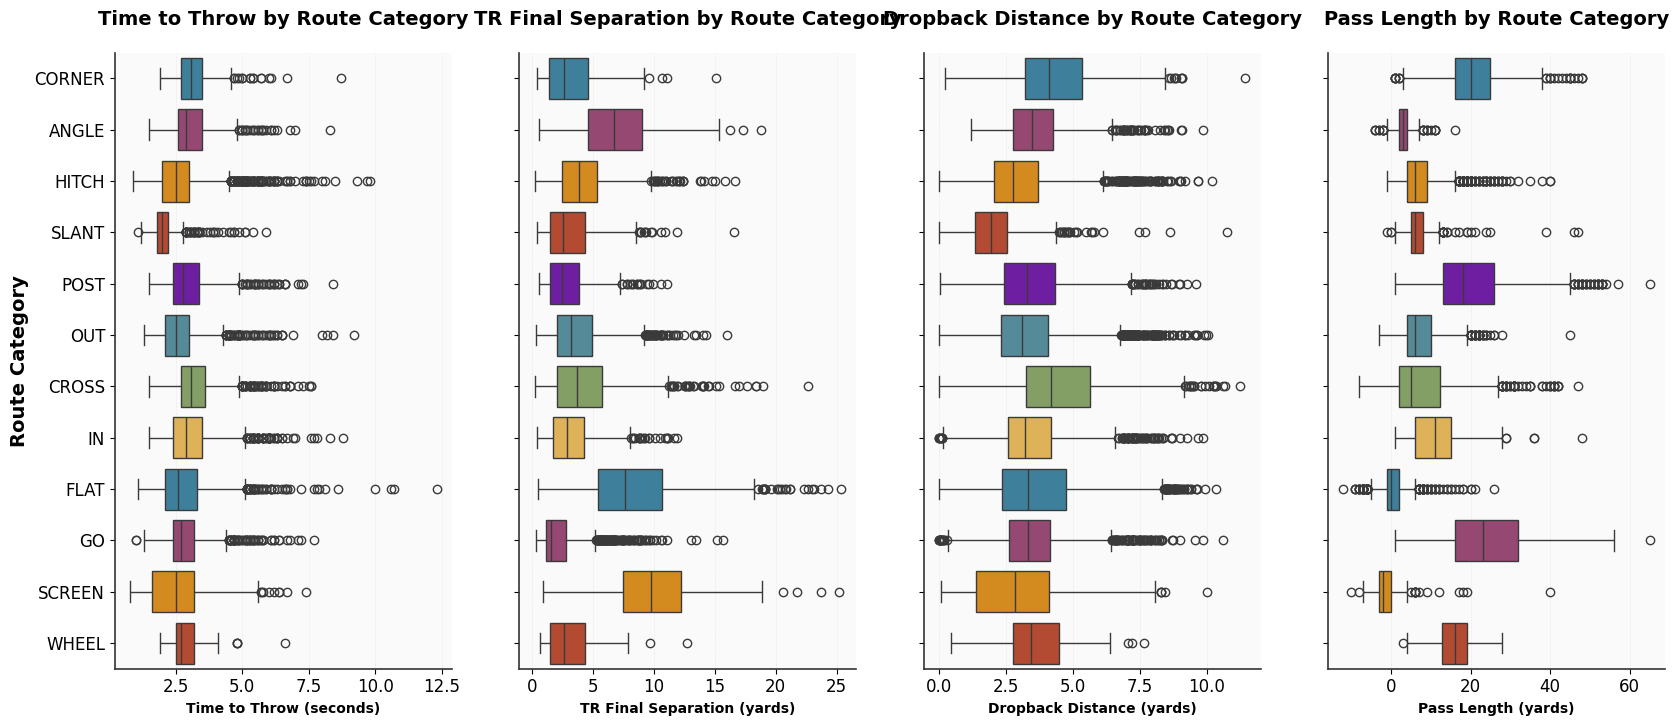


ROUTE ANALYSIS SUMMARY STATISTICS

CORNER (n=509):
  Time to Throw: 3.19s ± 0.70s
  Final Separation: 3.15 ± 2.10 yards
  Pass Length: 20.82 ± 8.73 yards
  Dropback Distance: 4.37 ± 1.72 yards

ANGLE (n=543):
  Time to Throw: 3.14s ± 0.84s
  Final Separation: 6.89 ± 3.34 yards
  Pass Length: 2.98 ± 2.21 yards
  Dropback Distance: 3.78 ± 1.51 yards

HITCH (n=2660):
  Time to Throw: 2.69s ± 0.97s
  Final Separation: 4.04 ± 2.14 yards
  Pass Length: 7.35 ± 4.54 yards
  Dropback Distance: 3.01 ± 1.45 yards

SLANT (n=1049):
  Time to Throw: 2.07s ± 0.48s
  Final Separation: 3.12 ± 2.03 yards
  Pass Length: 6.63 ± 3.30 yards
  Dropback Distance: 2.02 ± 1.05 yards

POST (n=769):
  Time to Throw: 3.04s ± 0.96s
  Final Separation: 2.87 ± 1.74 yards
  Pass Length: 21.25 ± 11.52 yards
  Dropback Distance: 3.55 ± 1.68 yards

OUT (n=2214):
  Time to Throw: 2.67s ± 0.79s
  Final Separation: 3.68 ± 2.17 yards
  Pass Length: 7.31 ± 5.02 yards
  Dropback Distance: 3.38 ± 1.66 yards

CROSS (n=1496):
  

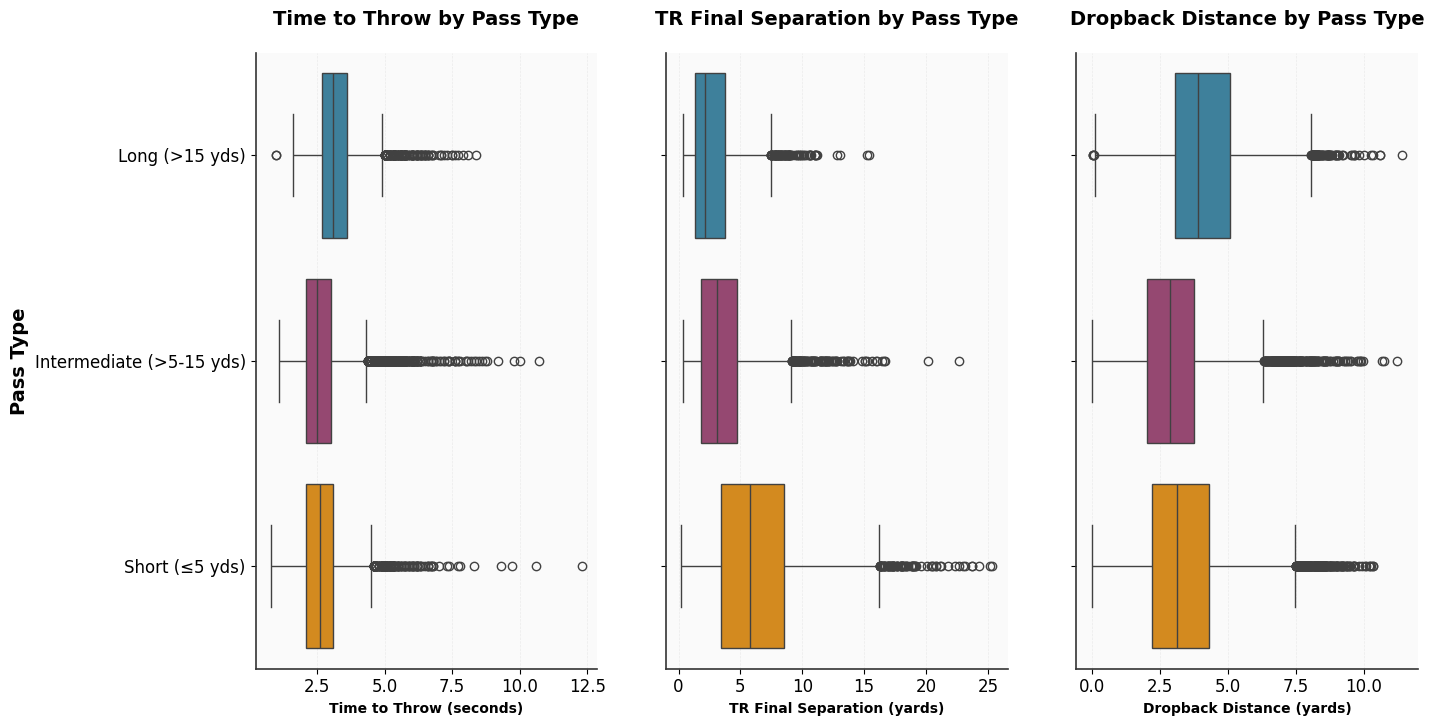

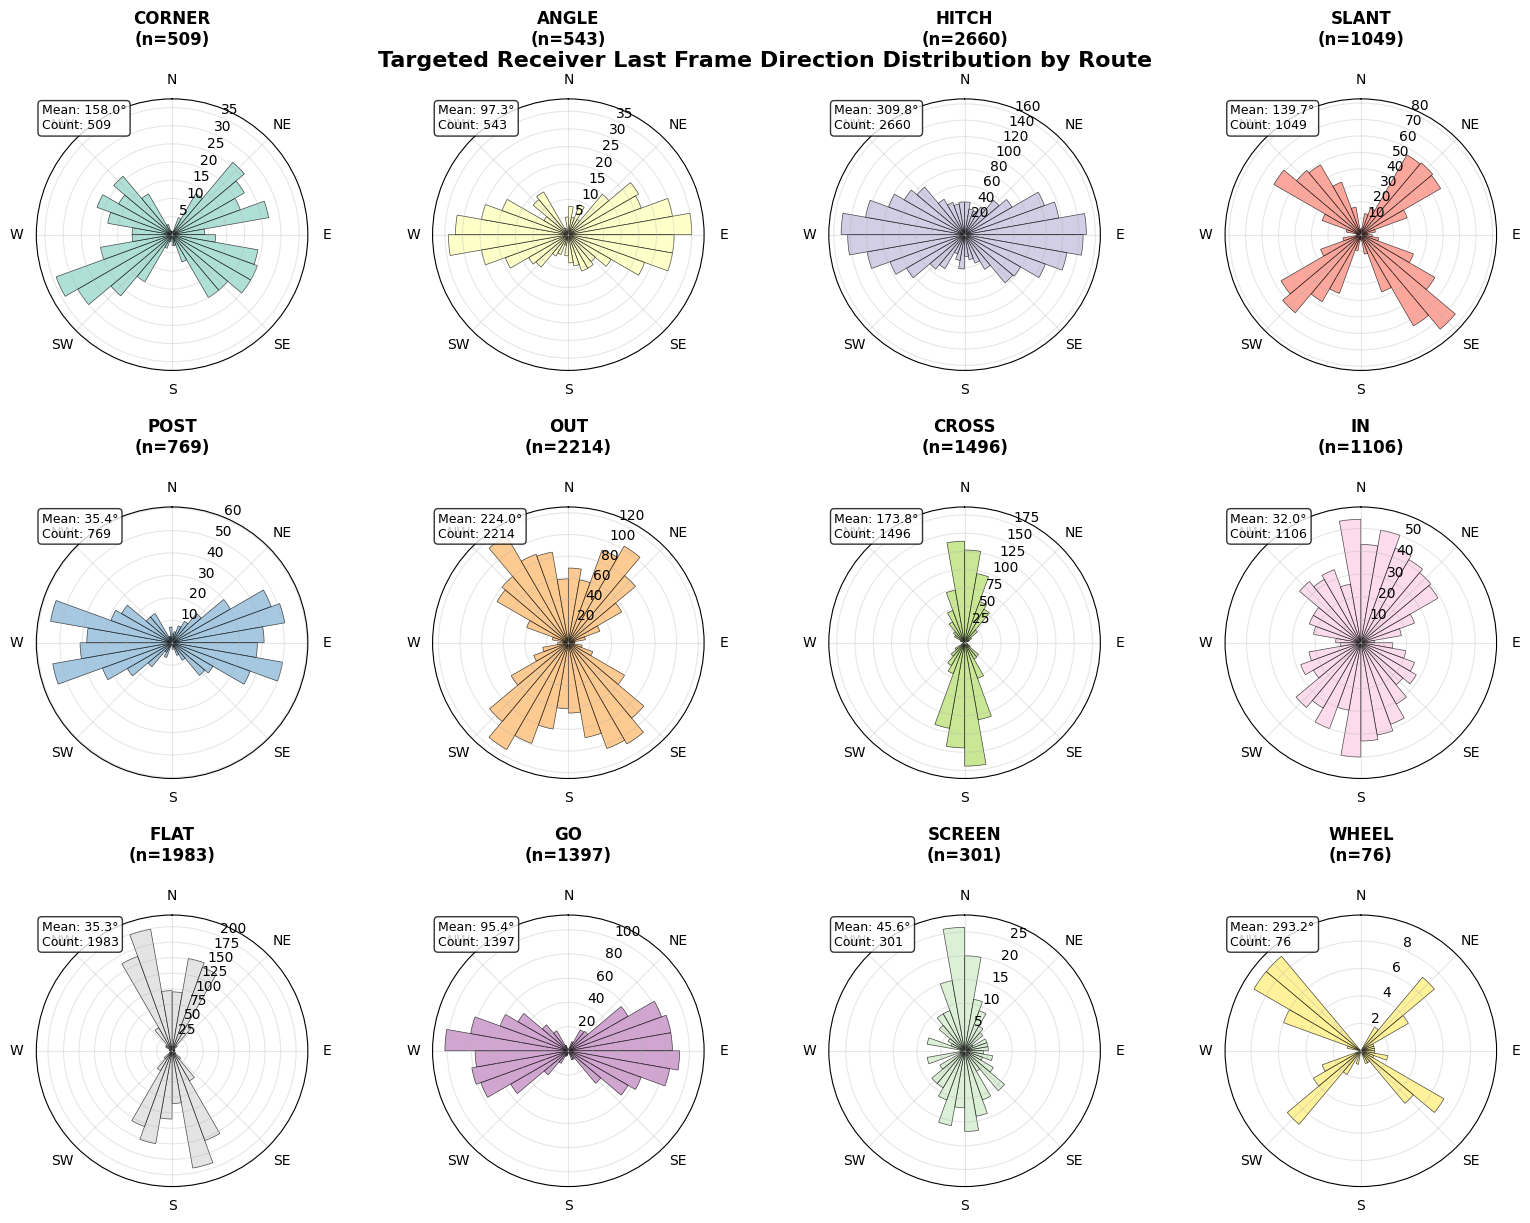


DIRECTION DISTRIBUTION SUMMARY BY ROUTE
CORNER               | Count: 509 | Mean Direction:  158.0° | Range:   15.3° -  350.5°
ANGLE                | Count: 543 | Mean Direction:   97.3° | Range:    0.1° -  359.4°
HITCH                | Count: 2660 | Mean Direction:  309.8° | Range:    0.2° -  359.8°
SLANT                | Count: 1049 | Mean Direction:  139.7° | Range:    1.6° -  354.0°
POST                 | Count: 769 | Mean Direction:   35.4° | Range:    0.2° -  359.9°
OUT                  | Count: 2214 | Mean Direction:  224.0° | Range:    0.0° -  359.8°
CROSS                | Count: 1496 | Mean Direction:  173.8° | Range:    0.0° -  359.9°
IN                   | Count: 1106 | Mean Direction:   32.0° | Range:    0.4° -  359.9°
FLAT                 | Count: 1983 | Mean Direction:   35.3° | Range:    0.1° -  360.0°
GO                   | Count: 1397 | Mean Direction:   95.4° | Range:    1.5° -  337.4°
SCREEN               | Count: 301 | Mean Direction:   45.6° | Range:    1.3° -  35

In [ ]:
from pathlib import Path

## Route impact analysis
def analyze_route_impact(merged_data):
    """
    Analyze how route types affect:
    - TR separation metrics 
    - QB min separation - QB in Pressure
    - Pass completion rates
    - Time to throw
    """
    route_analysis = merged_data.groupby('route_of_targeted_receiver').agg({
        'tr_play_avg_separation': ['mean', 'std'],
        'qb_play_min_separation': ['mean', 'std'],
        'time_to_throw': ['mean'],
        'pass_length': ['mean', 'std'],
        'pass_result': lambda x: (x == 'C').mean()  # Completion rate
    })
    return route_analysis

route_impact = analyze_route_impact(merged_data)
print(f"\n{'='*70}")
print(route_impact)     

#----------------------------------------------------------------
# Visualization Section
#----------------------------------------------------------------
# Targeted Receiver Analysis by Route Category - Enhanced with Y-axis Routes

# Set up the plotting style for better aesthetics
plt.style.use('default')
sns.set_palette("husl")

# Create figure with 1x4 layout
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Define a professional color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#4A90A4', '#83A95C', '#F4B942']

# Plot 1: Time to Throw vs Route (horizontal boxplot)
sns.boxplot(data=merged_data, y='route_of_targeted_receiver', x='time_to_throw', 
            ax=axes[0], palette=colors, orient='h')
axes[0].set_title('Time to Throw by Route Category', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Route Category', fontsize=14, fontweight='semibold')
axes[0].set_xlabel('Time to Throw (seconds)', fontsize=10, fontweight='semibold')
axes[0].tick_params(axis='y', labelsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[0].set_facecolor('#fafafa')

# Plot 2: Final Separation vs Route (horizontal boxplot) - Remove Y labels
sns.boxplot(data=merged_data, y='route_of_targeted_receiver', x='tr_min_separation_last',
            ax=axes[1], palette=colors, orient='h')
axes[1].set_title('TR Final Separation by Route Category', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('')  # Remove ylabel
axes[1].set_xlabel('TR Final Separation (yards)', fontsize=10, fontweight='semibold')
axes[1].tick_params(axis='y', labelleft=False)  # Hide y-axis labels
axes[1].tick_params(axis='x', labelsize=12)
axes[1].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[1].set_facecolor('#fafafa')

# Plot 3: Dropback Distance vs Route (horizontal boxplot) - Remove Y labels
sns.boxplot(data=merged_data, y='route_of_targeted_receiver', x='dropback_distance', 
            ax=axes[2], palette=colors, orient='h')
axes[2].set_title('Dropback Distance by Route Category', fontsize=14, fontweight='bold', pad=20)
axes[2].set_ylabel('')  # Remove ylabel
axes[2].set_xlabel('Dropback Distance (yards)', fontsize=10, fontweight='semibold')
axes[2].tick_params(axis='y', labelleft=False)  # Hide y-axis labels
axes[2].tick_params(axis='x', labelsize=12)
axes[2].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[2].set_facecolor('#fafafa')

# Plot 4: Pass Length vs Route (horizontal boxplot) - Remove Y labels
sns.boxplot(data=merged_data, y='route_of_targeted_receiver', x='pass_length', 
            ax=axes[3], palette=colors, orient='h')
axes[3].set_title('Pass Length by Route Category', fontsize=14, fontweight='bold', pad=20)
axes[3].set_ylabel('')  # Remove ylabel
axes[3].set_xlabel('Pass Length (yards)', fontsize=10, fontweight='semibold')
axes[3].tick_params(axis='y', labelleft=False)  # Hide y-axis labels
axes[3].tick_params(axis='x', labelsize=12)
axes[3].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[3].set_facecolor('#fafafa')

# Apply consistent styling to all subplots
for ax in axes.flat:
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Make remaining spines thicker and darker
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color('#333333')
    ax.spines['left'].set_color('#333333')
plt.show()
plt.close()
plt.show()
plt.close()

# Print summary statistics for better understanding
print(f"\n{'='*80}")
print("ROUTE ANALYSIS SUMMARY STATISTICS")
print("="*80)

# Get route counts for reference
route_counts = merged_data['route_of_targeted_receiver'].value_counts()

for route in merged_data['route_of_targeted_receiver'].dropna().unique():
    route_data = merged_data[merged_data['route_of_targeted_receiver'] == route]
    print(f"\n{route.upper()} (n={len(route_data)}):")
    print(f"  Time to Throw: {route_data['time_to_throw'].mean():.2f}s ± {route_data['time_to_throw'].std():.2f}s")
    print(f"  Final Separation: {route_data['tr_min_separation_last'].mean():.2f} ± {route_data['tr_min_separation_last'].std():.2f} yards")
    print(f"  Pass Length: {route_data['pass_length'].mean():.2f} ± {route_data['pass_length'].std():.2f} yards")
    print(f"  Dropback Distance: {route_data['dropback_distance'].mean():.2f} ± {route_data['dropback_distance'].std():.2f} yards")


# Targeted Receiver Analysis by Pass type - Enhanced with Y-axis types
# Same as above but for pass_type instead of route_of_targeted_receiver except pass length and 1x3 layout
# Create figure with 1x3 layout
# Add pass lenngth per pass type in plot y axis along with pass type

fig, axes = plt.subplots(1, 3, figsize=(15, 8))    
# Define a professional color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#4A90A4', '#83A95C', '#F4B942']
# Create custom y-axis labels with yards range
pass_type_labels = {
    'short': 'Short (≤5 yds)',
    'intermediate': 'Intermediate (>5-15 yds)', 
    'long': 'Long (>15 yds)'
}
# Plot 1: Time to Throw vs Pass Type (horizontal boxplot)
sns.boxplot(data=merged_data, y='pass_type', x='time_to_throw', 
            ax=axes[0], palette=colors, orient='h')
axes[0].set_title('Time to Throw by Pass Type', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Pass Type', fontsize=14, fontweight='semibold')
axes[0].set_xlabel('Time to Throw (seconds)', fontsize=10, fontweight='semibold')
axes[0].tick_params(axis='y', labelsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[0].set_facecolor('#fafafa')
# Plot 2: Final Separation vs Pass Type (horizontal boxplot) - Remove Y labels
sns.boxplot(data=merged_data, y='pass_type', x='tr_min_separation_last',
            ax=axes[1], palette=colors, orient='h')
axes[1].set_title('TR Final Separation by Pass Type', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('')  # Remove ylabel
axes[1].set_xlabel('TR Final Separation (yards)', fontsize=10, fontweight='semibold')
axes[1].tick_params(axis='y', labelleft=False)  # Hide y-axis labels
axes[1].tick_params(axis='x', labelsize=12)
axes[1].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[1].set_facecolor('#fafafa')
# Plot 3: Dropback Distance vs Pass Type (horizontal boxplot) - Remove Y labels
sns.boxplot(data=merged_data, y='pass_type', x='dropback_distance', 
            ax=axes[2], palette=colors, orient='h')
axes[2].set_title('Dropback Distance by Pass Type', fontsize=14, fontweight='bold', pad=20)
axes[2].set_ylabel('')  # Remove ylabel
axes[2].set_xlabel('Dropback Distance (yards)', fontsize=10, fontweight='semibold')
axes[2].tick_params(axis='y', labelleft=False)  # Hide y-axis labels
axes[2].tick_params(axis='x', labelsize=12)
axes[2].grid(True, alpha=0.2, linestyle='--', linewidth=0.5, axis='x')
axes[2].set_facecolor('#fafafa')

# Apply y-axis labels with yards range to all plots at once
for ax in axes:
    ax.set_yticklabels([pass_type_labels.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])

# Apply consistent styling to all subplots
for ax in axes.flat:
    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Make remaining spines thicker and darker
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color('#333333')
    ax.spines['left'].set_color('#333333')
plt.show()
plt.close() 
plt.show()
plt.close() 


###--------------------------------
# Visualize player direction in last frame distribution per category - one polar diagram per route
###--------------------------------

# Get unique routes and create subplot layout
unique_routes = play_level_qb_tr['route_of_targeted_receiver'].dropna().unique()
n_routes = len(unique_routes)

# Calculate grid dimensions (try to make it roughly square)
n_cols = int(np.ceil(np.sqrt(n_routes)))
n_rows = int(np.ceil(n_routes / n_cols))

# Create figure with polar subplots
fig = plt.figure(figsize=(4*n_cols, 4*n_rows))
fig.suptitle('Targeted Receiver Last Frame Direction Distribution by Route', fontsize=16, fontweight='bold', y=0.98)

# Define colors for each route
colors = plt.cm.Set3(np.linspace(0, 1, n_routes))

for i, route in enumerate(unique_routes):
    # Create polar subplot
    ax = fig.add_subplot(n_rows, n_cols, i+1, polar=True)
    
    # Filter data for this route
    route_data = play_level_qb_tr[play_level_qb_tr['route_of_targeted_receiver'] == route]
    
    if not route_data.empty and route_data['tr_last_dir'].notna().any():
        # Convert degrees to radians
        directions_rad = np.deg2rad(route_data['tr_last_dir'].dropna())
        
        # Create histogram bins (36 bins = 10 degree intervals)
        n_bins = 36
        bins = np.linspace(0, 2*np.pi, n_bins + 1)
        
        # Calculate histogram
        hist, bin_edges = np.histogram(directions_rad, bins=bins)
        
        # Calculate bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Create bar plot
        bars = ax.bar(bin_centers, hist, width=2*np.pi/n_bins, 
                     color=colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Set title for this subplot
        ax.set_title(f'{route}\n(n={len(route_data)})', fontsize=12, fontweight='bold', pad=20)
        
        # Customize polar plot
        ax.set_theta_zero_location('N')  # 0 degrees at top
        ax.set_theta_direction(-1)       # Clockwise direction
        ax.set_thetagrids(range(0, 360, 45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
        
        # Set radial limits
        ax.set_ylim(0, max(hist) * 1.1 if max(hist) > 0 else 1)
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        mean_dir = np.rad2deg(np.arctan2(np.sin(directions_rad).mean(), np.cos(directions_rad).mean()))
        if mean_dir < 0:
            mean_dir += 360
        
        ax.text(0.02, 0.98, f'Mean: {mean_dir:.1f}°\nCount: {len(directions_rad)}', 
               transform=ax.transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    else:
        # Handle empty data case
        ax.set_title(f'{route}\n(No data)', fontsize=12, fontweight='bold', pad=20)
        ax.text(0.5, 0.5, 'No direction data\navailable', 
               transform=ax.transAxes, ha='center', va='center',
               fontsize=10, style='italic')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.94)  # Make room for suptitle
plt.show()
plt.close()  # Fix: Properly close figure

# Print summary statistics
print(f"\n{'='*70}")
print("DIRECTION DISTRIBUTION SUMMARY BY ROUTE")
print("="*70)
for route in unique_routes:
    route_data = play_level_qb_tr[play_level_qb_tr['route_of_targeted_receiver'] == route]
    if not route_data.empty and route_data['tr_last_dir'].notna().any():
        directions = route_data['tr_last_dir'].dropna()
        directions_rad = np.deg2rad(directions)
        
        # Calculate circular mean
        mean_dir = np.rad2deg(np.arctan2(np.sin(directions_rad).mean(), np.cos(directions_rad).mean()))
        if mean_dir < 0:
            mean_dir += 360
            
        print(f"{route:20} | Count: {len(directions):3d} | Mean Direction: {mean_dir:6.1f}° | Range: {directions.min():6.1f}° - {directions.max():6.1f}°")
    else:
        print(f"{route:20} | No direction data available")


# Visual Analysis

The visual analysis covers four key areas:

1. **Temporal Separation Dynamics** - How separation evolves over time during pre-throw phases
2. **Route-Specific Performance Metrics** - Comparative analysis across different receiver route types  
3. **Contextual Factor Impact** - How game situations affect separation (formation, pressure, play action)
4. **Player Direction Analysis** - Targeted receiver movement patterns in final pre-throw frames

## 1. Temporal Separation Analysis

**Purpose**: Track how separation between players and defenders changes throughout the pre-throw period.

**Key Insights**:
- Frame-by-frame separation evolution for both QB and TR
- Identification of pressure buildup patterns
- Time-to-throw relationship with separation maintenance
- Individual player vs. aggregate play analysis

In [11]:
def plot_receiver_separation_by_time(df, game_id, play_id=None, player_id=None):
    """
    Display line chart of minimum separation distance vs time for a selected game, with optional play and player filters.
    
    Parameters:
    df: DataFrame with separation data (should contain game_id, play_id, nfl_id, frame_id, tr_min_separation, player_name)
    game_id: Game identifier (required)
    play_id: Play identifier (optional - if None)
    player_id: Player NFL ID (optional - if None)
    
    Returns:
    None (displays plot)
    """
    
    # Start with game filter (required)
    filtered_data = df[df['game_id'] == game_id].copy()
    
    # Apply optional filters
    if play_id is not None:
        filtered_data = filtered_data[filtered_data['play_id'] == play_id]
    
    if player_id is not None:
        filtered_data = filtered_data[filtered_data['nfl_id'] == player_id]
    
    if filtered_data.empty:
        print(f"No data found for Game {game_id}" + 
              (f", Play {play_id}" if play_id else "") + 
              (f", Player {player_id}" if player_id else ""))
        return
    
    # Convert frame_id to time in seconds (each frame = 0.1 seconds)
    filtered_data['time_seconds'] = filtered_data['frame_id'] * 0.1
    
    # Sort by time for proper line plotting
    filtered_data = filtered_data.sort_values(['nfl_id', 'play_id', 'time_seconds'])
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Determine what to plot based on filters
    if play_id is not None and player_id is not None:
        # Single player, single play
        player_name = filtered_data['player_name'].iloc[0] if 'player_name' in filtered_data.columns else f"Player {player_id}"
        player_position = filtered_data['player_position'].iloc[0] if 'player_position' in filtered_data.columns else 'N/A'
        
        plt.plot(filtered_data['time_seconds'], filtered_data['tr_min_separation'], 
                 marker='o', linewidth=2.5, markersize=6, color='#2E86AB',
                 label=f'{player_name} ({player_position})')
        plt.legend()
        title = f'{player_name} - Minimum Separation Over Time\nGame {game_id}, Play {play_id}'
        
    elif play_id is not None:
        # All plays for selected player - define player_name before the loop
        player_name = filtered_data['player_name'].iloc[0] if 'player_name' in filtered_data.columns else f"Player {player_id}"
        
        # Group by play_id and plot each play as a separate line
        for play_id_inner, play_data in filtered_data.groupby('play_id'):
            player_position = play_data['player_position'].iloc[0] if 'player_position' in play_data.columns else 'N/A'
            plt.plot(play_data['time_seconds'], play_data['tr_min_separation'], 
                     marker='o', label=f'Play {play_id_inner} ({player_position})', linewidth=2, markersize=4)
        
        plt.legend()
        title = f'Selected Receiver - Minimum Separation Over Time\nGame {game_id}, Play {play_id}'
               
    else:
        # all plays and all players in plays  - limit to first 10 plays if more than 10
        # First, get unique plays in the game
        unique_plays = sorted(filtered_data['play_id'].unique())
        
        # Check if game has more than 10 plays
        if len(unique_plays) > 10:
            # Select first 10 plays
            selected_plays = unique_plays[:10]
            filtered_data = filtered_data[filtered_data['play_id'].isin(selected_plays)]
            
        else:
            selected_plays = unique_plays
            print(f"Showing all {len(unique_plays)} plays")
        
        # Define line styles for better distinction
        line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

       # Plot each play as a separate line, grouped by play_id only
        for i, (play_id_loop, play_data) in enumerate(filtered_data.groupby('play_id')):
            # Since each play has only one QB, no need to group by nfl_id
            player_name = play_data['player_name'].iloc[0] if 'player_name' in play_data.columns else f"Play {play_id_loop}"
            player_position = play_data['player_position'].iloc[0] if 'player_position' in play_data.columns else 'N/A'
            
            # Use line styles for better distinction between plays
            line_style = line_styles[i % len(line_styles)]
            
            plt.plot(play_data['time_seconds'], play_data['tr_min_separation'], 
                    marker='o', 
                    label=f'{player_name} ({player_position}) - Play {play_id_loop}',
                    linestyle=line_style,
                    linewidth=1.5, markersize=3, alpha=0.7)         
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        if len(unique_plays) > 10:
            title = f'All Receivers - First 10 Plays\nGame {game_id}'
        else:
            title = f'All Receivers - All Plays\nGame {game_id}'
    
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Minimum Separation (yards)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show statistics on the plot
    min_sep = filtered_data['tr_min_separation'].min()
    max_sep = filtered_data['tr_min_separation'].max()
    avg_sep = filtered_data['tr_min_separation'].mean()
    
    plt.text(0.02, 0.98, f'Min: {min_sep:.2f} yds\nMax: {max_sep:.2f} yds\nAvg: {avg_sep:.2f} yds', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Data points: {len(filtered_data)}")
    print(f"Time range: {filtered_data['time_seconds'].min():.1f}s - {filtered_data['time_seconds'].max():.1f}s")
    print(f"Separation range: {min_sep:.2f} - {max_sep:.2f} yards")
    if play_id is None:
        displayed_plays = sorted(filtered_data['play_id'].unique())
        print(f"Plays displayed: {displayed_plays}")
    if player_id is None:
        print(f"Players included: {len(filtered_data['nfl_id'].unique())}")

In [12]:
def plot_qb_separation_by_time(df, game_id, play_id=None, player_id=None):
    """
    Display line chart of minimum separation distance vs time for a selected game, with optional play and player filters.
    
    Parameters:
    df: DataFrame with separation data (should contain game_id, play_id, nfl_id, frame_id, qb_min_separation, player_name)
    game_id: Game identifier (required)
    play_id: Play identifier (optional - if None)
    player_id: Player NFL ID (optional - if None)
    
    Returns:
    None (displays plot)
    """
    
    # Start with game filter (required)
    filtered_data = df[df['game_id'] == game_id].copy()
    
    # Apply optional filters
    if play_id is not None:
        filtered_data = filtered_data[filtered_data['play_id'] == play_id]
    
    if player_id is not None:
        filtered_data = filtered_data[filtered_data['nfl_id'] == player_id]
    
    if filtered_data.empty:
        print(f"No data found for Game {game_id}" + 
              (f", Play {play_id}" if play_id else "") + 
              (f", Player {player_id}" if player_id else ""))
        return
    
    # Convert frame_id to time in seconds (each frame = 0.1 seconds)
    filtered_data['time_seconds'] = filtered_data['frame_id'] * 0.1
    
    # Sort by time for proper line plotting
    filtered_data = filtered_data.sort_values(['nfl_id', 'play_id', 'time_seconds'])
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Determine what to plot based on filters
    if play_id is not None and player_id is not None:
        # Single player, single play
        player_name = filtered_data['player_name'].iloc[0] if 'player_name' in filtered_data.columns else f"Player {player_id}"
        plt.plot(filtered_data['time_seconds'], filtered_data['qb_min_separation'], 
                 marker='o', linewidth=2.5, markersize=6, color='#2E86AB')
        title = f'{player_name} - Minimum Separation Over Time\nGame {game_id}, Play {play_id}'
        
    elif play_id is not None:
        # All plays for selected player
        # Group by play_id and plot each play as a separate line
        for play_id, play_data in filtered_data.groupby('play_id'):
            plt.plot(play_data['time_seconds'], play_data['qb_min_separation'], 
                     marker='o', label=f'Play {play_id}', linewidth=2, markersize=4)
        player_name = filtered_data['player_name'].iloc[0] if 'player_name' in filtered_data.columns else f"Player {player_id}"
        plt.legend()
        title = f'Selected QB - Minimum Separation Over Time\nGame {game_id}, Play {play_id}'
               
    else:
        # all plays and all players in plays  - limit to first 10 plays if more than 10
        # First, get unique plays in the game
        unique_plays = sorted(filtered_data['play_id'].unique())
        
        # Check if game has more than 10 plays
        if len(unique_plays) > 10:
            # Select first 10 plays
            selected_plays = unique_plays[:10]
            filtered_data = filtered_data[filtered_data['play_id'].isin(selected_plays)]
            
        else:
            selected_plays = unique_plays
            
        
        # Define line styles for better distinction
        line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

       # Plot each play as a separate line, grouped by play_id only
        for i, (play_id_loop, play_data) in enumerate(filtered_data.groupby('play_id')):
            # Since each play has only one QB, no need to group by nfl_id
            player_name = play_data['player_name'].iloc[0] if 'player_name' in play_data.columns else f"Play {play_id_loop}"
            
            # Use line styles for better distinction between plays
            line_style = line_styles[i % len(line_styles)]
            
            plt.plot(play_data['time_seconds'], play_data['qb_min_separation'], 
                    marker='o', 
                    label=f'{player_name} - Play {play_id_loop}',
                    linestyle=line_style,
                    linewidth=1.5, markersize=3, alpha=0.7)         
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        if len(unique_plays) > 10:
            title = f'All QBs - First 10 Plays\nGame {game_id}'
        else:
            title = f'All QBs - All Plays\nGame {game_id}'
    
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Minimum Separation (yards)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Show statistics on the plot
    min_sep = filtered_data['qb_min_separation'].min()
    max_sep = filtered_data['qb_min_separation'].max()
    avg_sep = filtered_data['qb_min_separation'].mean()
    
    plt.text(0.02, 0.98, f'Min: {min_sep:.2f} yds\nMax: {max_sep:.2f} yds\nAvg: {avg_sep:.2f} yds', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Data points: {len(filtered_data)}")
    print(f"Time range: {filtered_data['time_seconds'].min():.1f}s - {filtered_data['time_seconds'].max():.1f}s")
    print(f"Separation range: {min_sep:.2f} - {max_sep:.2f} yards")
    if play_id is None:
        displayed_plays = sorted(filtered_data['play_id'].unique())
        print(f"Plays displayed: {displayed_plays}")
    if player_id is None:
        print(f"Players included: {len(filtered_data['nfl_id'].unique())}")


STEP 6: PLOTTING QB SEPARATION BY TIME WITH FLEXIBLE OPTIONS

Example 2: One player across all plays


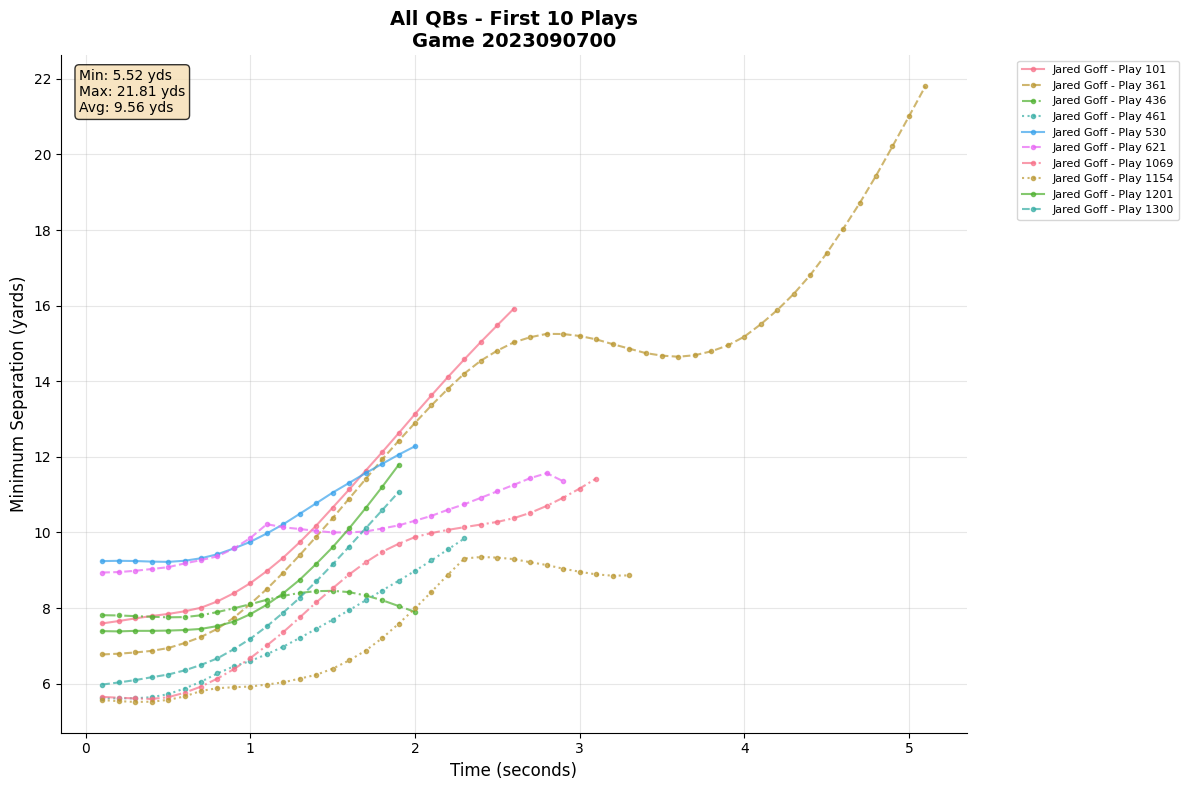

Data points: 271
Time range: 0.1s - 5.1s
Separation range: 5.52 - 21.81 yards
Plays displayed: [np.int64(101), np.int64(361), np.int64(436), np.int64(461), np.int64(530), np.int64(621), np.int64(1069), np.int64(1154), np.int64(1201), np.int64(1300)]

Example 4: All players, all plays (with 10 play limit)


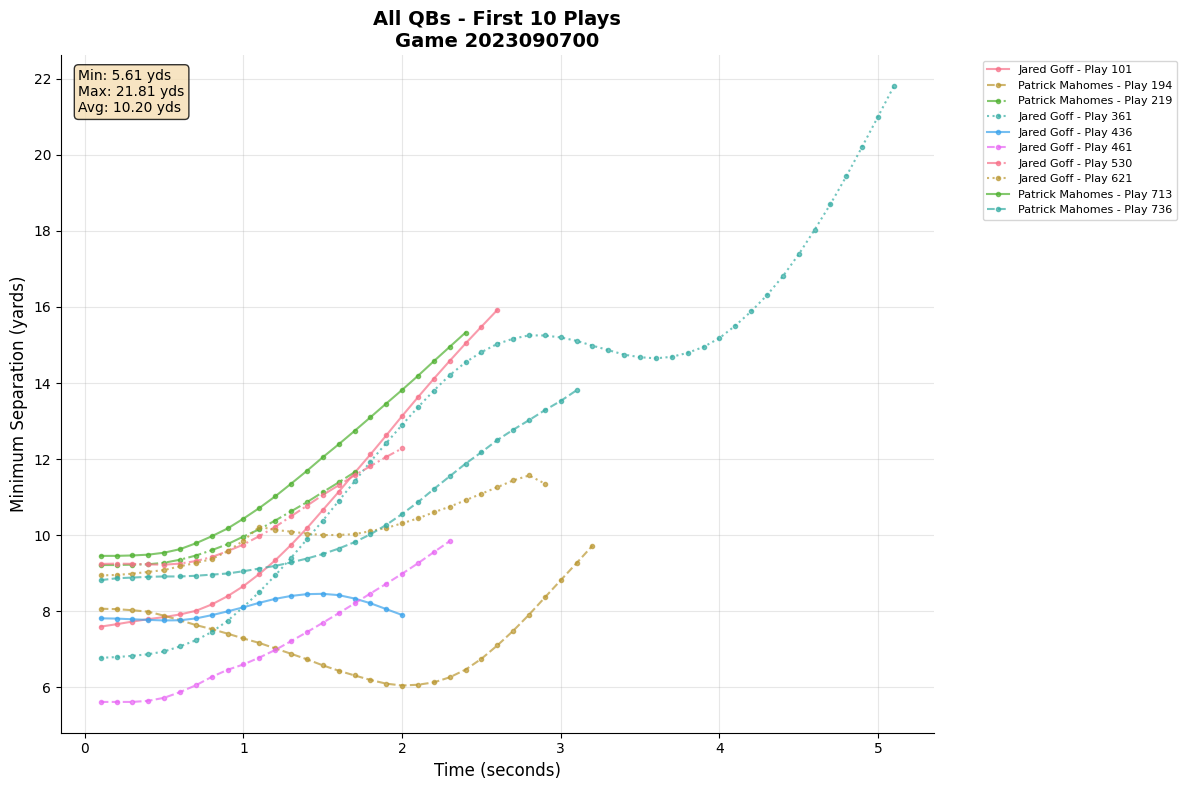

Data points: 273
Time range: 0.1s - 5.1s
Separation range: 5.61 - 21.81 yards
Plays displayed: [np.int64(101), np.int64(194), np.int64(219), np.int64(361), np.int64(436), np.int64(461), np.int64(530), np.int64(621), np.int64(713), np.int64(736)]
Players included: 2


In [13]:
# Example usage of the modified function with optional parameters
print(f"\n{'='*70}")
print("STEP 6: PLOTTING QB SEPARATION BY TIME WITH FLEXIBLE OPTIONS")
print("="*70)

selected_game_id = qb_separation_df['game_id'].iloc[0]
selected_play_id = qb_separation_df[qb_separation_df['game_id'] == selected_game_id]['play_id'].iloc[0]


# Example 2 One player across all plays i.e. Jared Goff nfl_id=43290
print("\nExample 2: One player across all plays")
plot_qb_separation_by_time(qb_separation_df, selected_game_id, player_id=43290)

# Example 4: All players, all plays (limited to first 10 if more than 10)
print("\nExample 4: All players, all plays (with 10 play limit)")
plot_qb_separation_by_time(qb_separation_df, selected_game_id)


STEP 4: PLOTTING RECEIVER SEPARATION BY TIME WITH FLEXIBLE OPTIONS
Example 1: Specific play


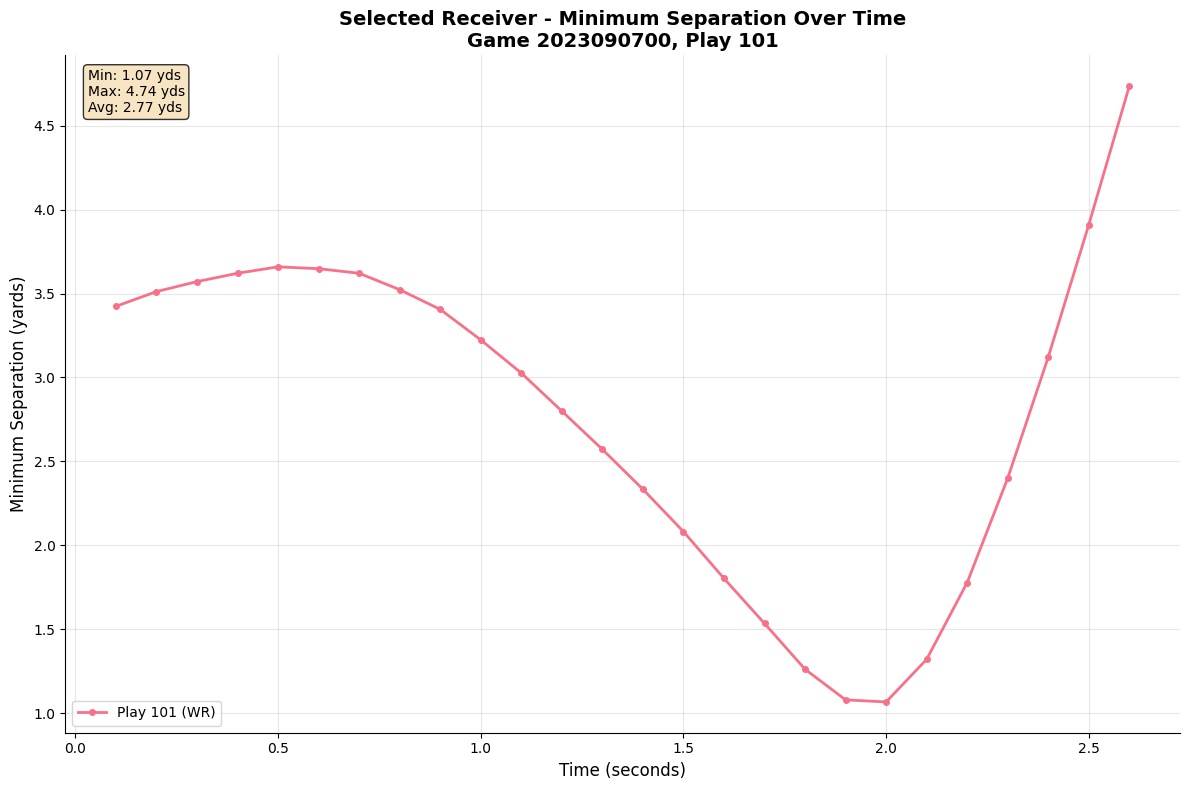

Data points: 26
Time range: 0.1s - 2.6s
Separation range: 1.07 - 4.74 yards
Players included: 1

Example 3: One player across all plays
Showing all 5 plays


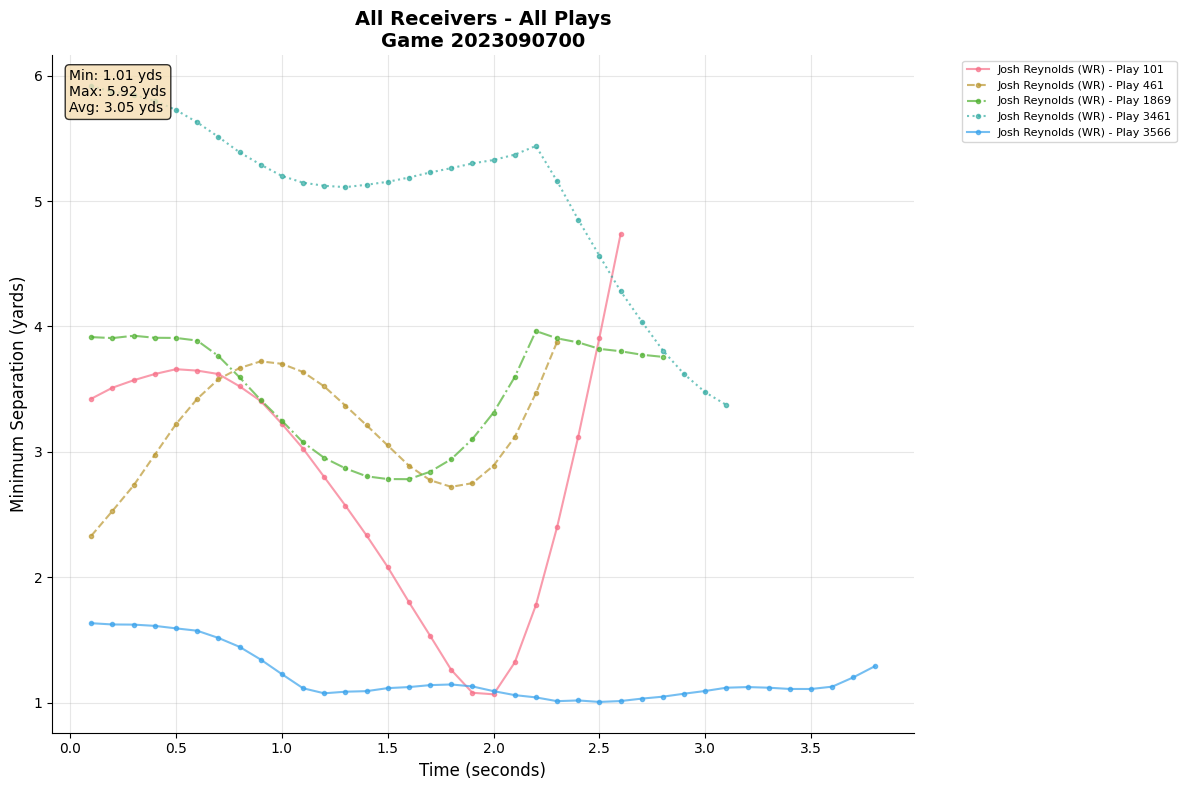

Data points: 146
Time range: 0.1s - 3.8s
Separation range: 1.01 - 5.92 yards
Plays displayed: [np.int64(101), np.int64(461), np.int64(1869), np.int64(3461), np.int64(3566)]

Example 4: All players, all plays (with 10 play limit)


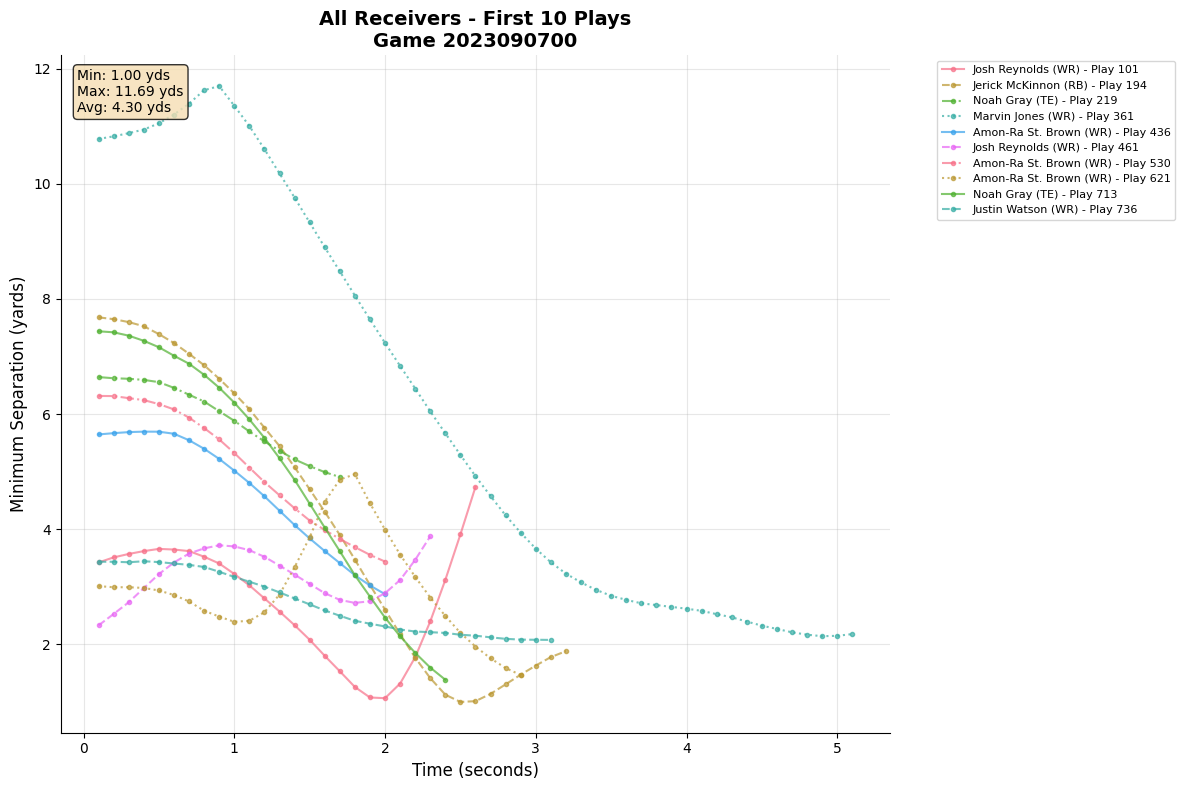

Data points: 273
Time range: 0.1s - 5.1s
Separation range: 1.00 - 11.69 yards
Plays displayed: [np.int64(101), np.int64(194), np.int64(219), np.int64(361), np.int64(436), np.int64(461), np.int64(530), np.int64(621), np.int64(713), np.int64(736)]
Players included: 6


In [14]:
# Example usage of the modified function with optional parameters
print(f"\n{'='*70}")
print("STEP 4: PLOTTING RECEIVER SEPARATION BY TIME WITH FLEXIBLE OPTIONS")
print("="*70)

selected_game_id = tr_separation_df['game_id'].iloc[0]
selected_play_id = tr_separation_df[tr_separation_df['game_id'] == selected_game_id]['play_id'].iloc[0]

# Example 1: Specific play (original functionality)
print("Example 1: Specific play")
plot_receiver_separation_by_time(tr_separation_df, selected_game_id, selected_play_id)

# Example 3: One player across all plays
print("\nExample 3: One player across all plays")
plot_receiver_separation_by_time(tr_separation_df, selected_game_id, player_id=44930)

# Example 4: All players, all plays (limited to first 10 if more than 10)
print("\nExample 4: All players, all plays (with 10 play limit)")
plot_receiver_separation_by_time(tr_separation_df, selected_game_id)

## 2. QB minimum separation Analysis

- comparing QB minimum separation across game context variables (pass result, formation, dropback type, defenders in box) to identify pressure patterns and situational performance differences

Original data: 14105 rows
Data for plotting (after removing NaN): 14105 rows
Data type of qb_play_min_separation: float64


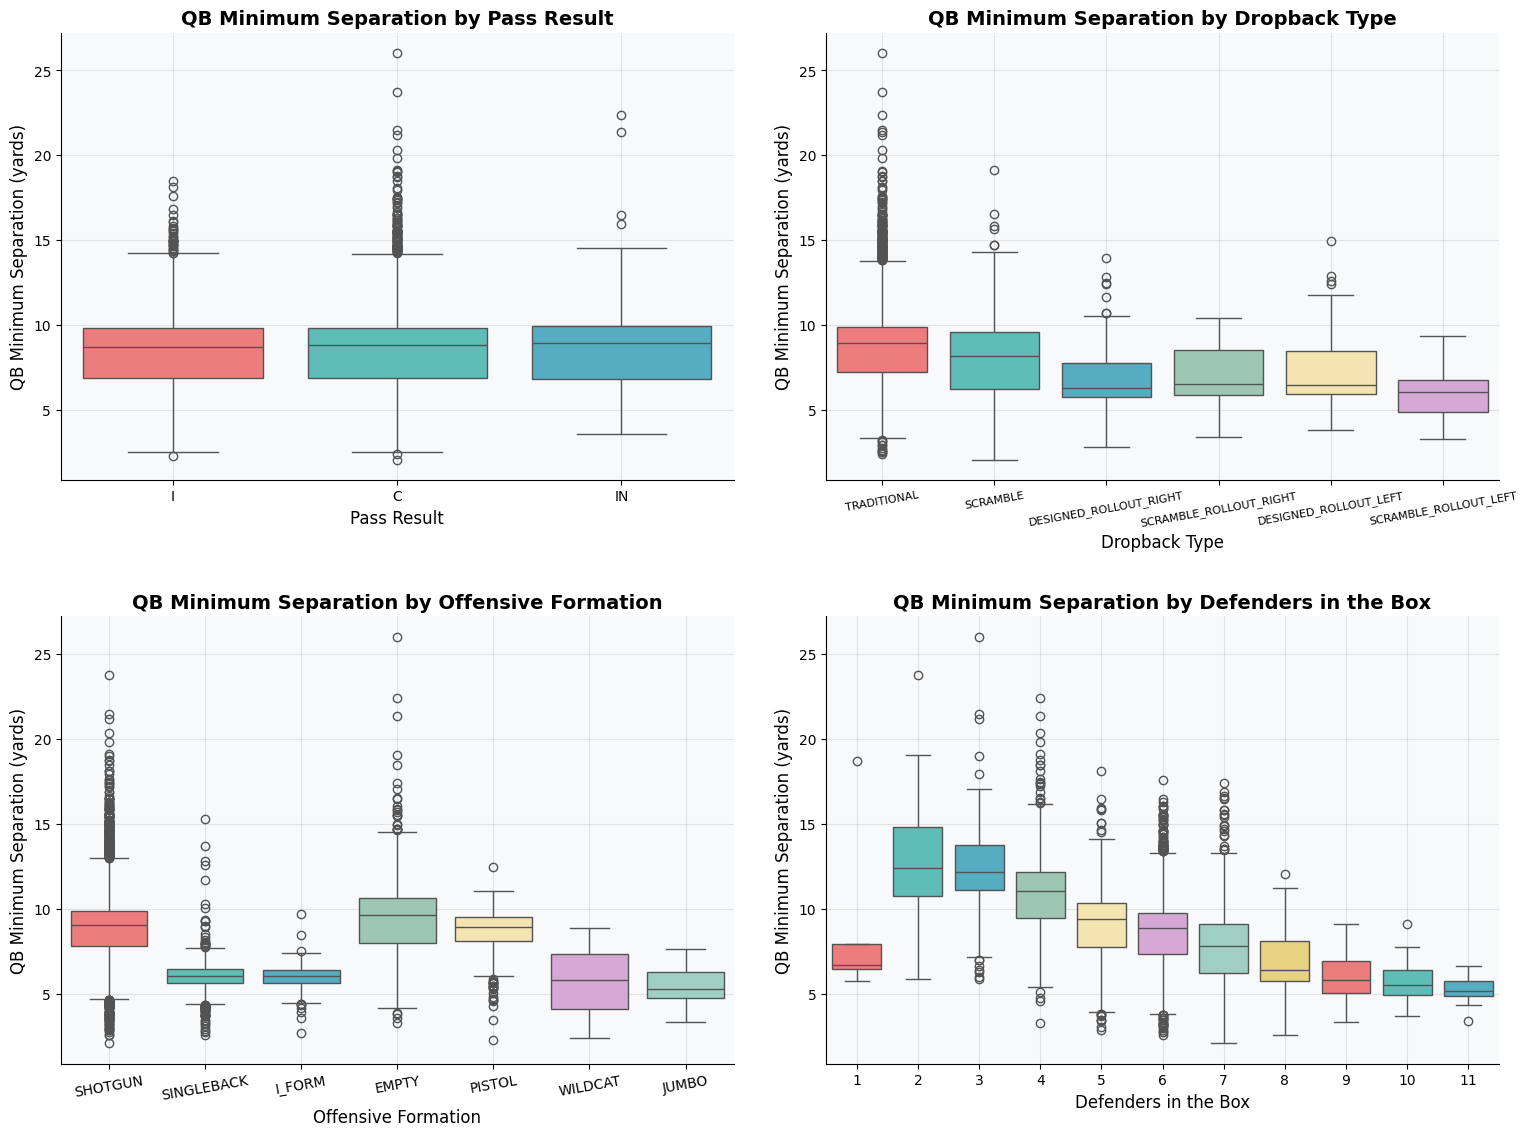

In [15]:
# Convert qb_play_min_separation to numeric and handle any invalid values
merged_data['qb_play_min_separation'] = pd.to_numeric(merged_data['qb_play_min_separation'], errors='coerce')

# Remove rows with NaN values in the separation column for plotting
plot_data = merged_data.dropna(subset=['qb_play_min_separation'])

print(f"Original data: {len(merged_data)} rows")
print(f"Data for plotting (after removing NaN): {len(plot_data)} rows")
print(f"Data type of qb_play_min_separation: {plot_data['qb_play_min_separation'].dtype}")

# Create box plots for QB play-level analysis
# Arrange subplots in a 2x2 grid starting from the top-left. 
# Each box plot will compare qb_play_min_separation against different categorical variables.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for better visual appeal
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

# Fix: Use seaborn instead of deprecated pandas boxplot method
import seaborn as sns

# Box plot 1: qb_play_min_separation vs pass_result
sns.boxplot(data=plot_data, x='pass_result', y='qb_play_min_separation', ax=axes[0, 0], palette=colors)
axes[0, 0].set_title('QB Minimum Separation by Pass Result', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Pass Result', fontsize=12)
axes[0, 0].set_ylabel('QB Minimum Separation (yards)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Box plot 2: qb_play_min_separation vs offense_formation
sns.boxplot(data=plot_data, x='offense_formation', y='qb_play_min_separation', ax=axes[1, 0], palette=colors)
axes[1, 0].set_title('QB Minimum Separation by Offensive Formation', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Offensive Formation', fontsize=12)
axes[1, 0].set_ylabel('QB Minimum Separation (yards)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=10, labelsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Box plot 3: qb_play_min_separation vs dropback_type
sns.boxplot(data=plot_data, x='dropback_type', y='qb_play_min_separation', ax=axes[0, 1], palette=colors)
axes[0, 1].set_title('QB Minimum Separation by Dropback Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Dropback Type', fontsize=12)
axes[0, 1].set_ylabel('QB Minimum Separation (yards)', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=10, labelsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Box plot 4: qb_play_min_separation vs defenders_in_the_box
sns.boxplot(data=plot_data, x='defenders_in_the_box', y='qb_play_min_separation', ax=axes[1, 1], palette=colors)
axes[1, 1].set_title('QB Minimum Separation by Defenders in the Box', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Defenders in the Box', fontsize=12)
axes[1, 1].set_ylabel('QB Minimum Separation (yards)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=0, labelsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Add background color and remove top/right spines for cleaner look
for ax in axes.flat:
    ax.set_facecolor('#f8f9fa')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()


## 3. Contextual Performance Analysis

**Purpose**: Examine how game context affects separation for both QB and TR.

**Variables Analyzed**:
- **Pass Result**: Completion vs. incompletion impact on separation
- **Offensive Formation**: How formation affects space creation
- **Dropback Type**: Traditional vs. rollout separation differences  
- **Defenders in Box**: Pressure impact on QB separation
- **Play Action**: Deception effect on defender positioning


STEP 7: COMPARATIVE VISUALIZATIONS FOR TARGETED RECEIVERS AND QUARTERBACKS


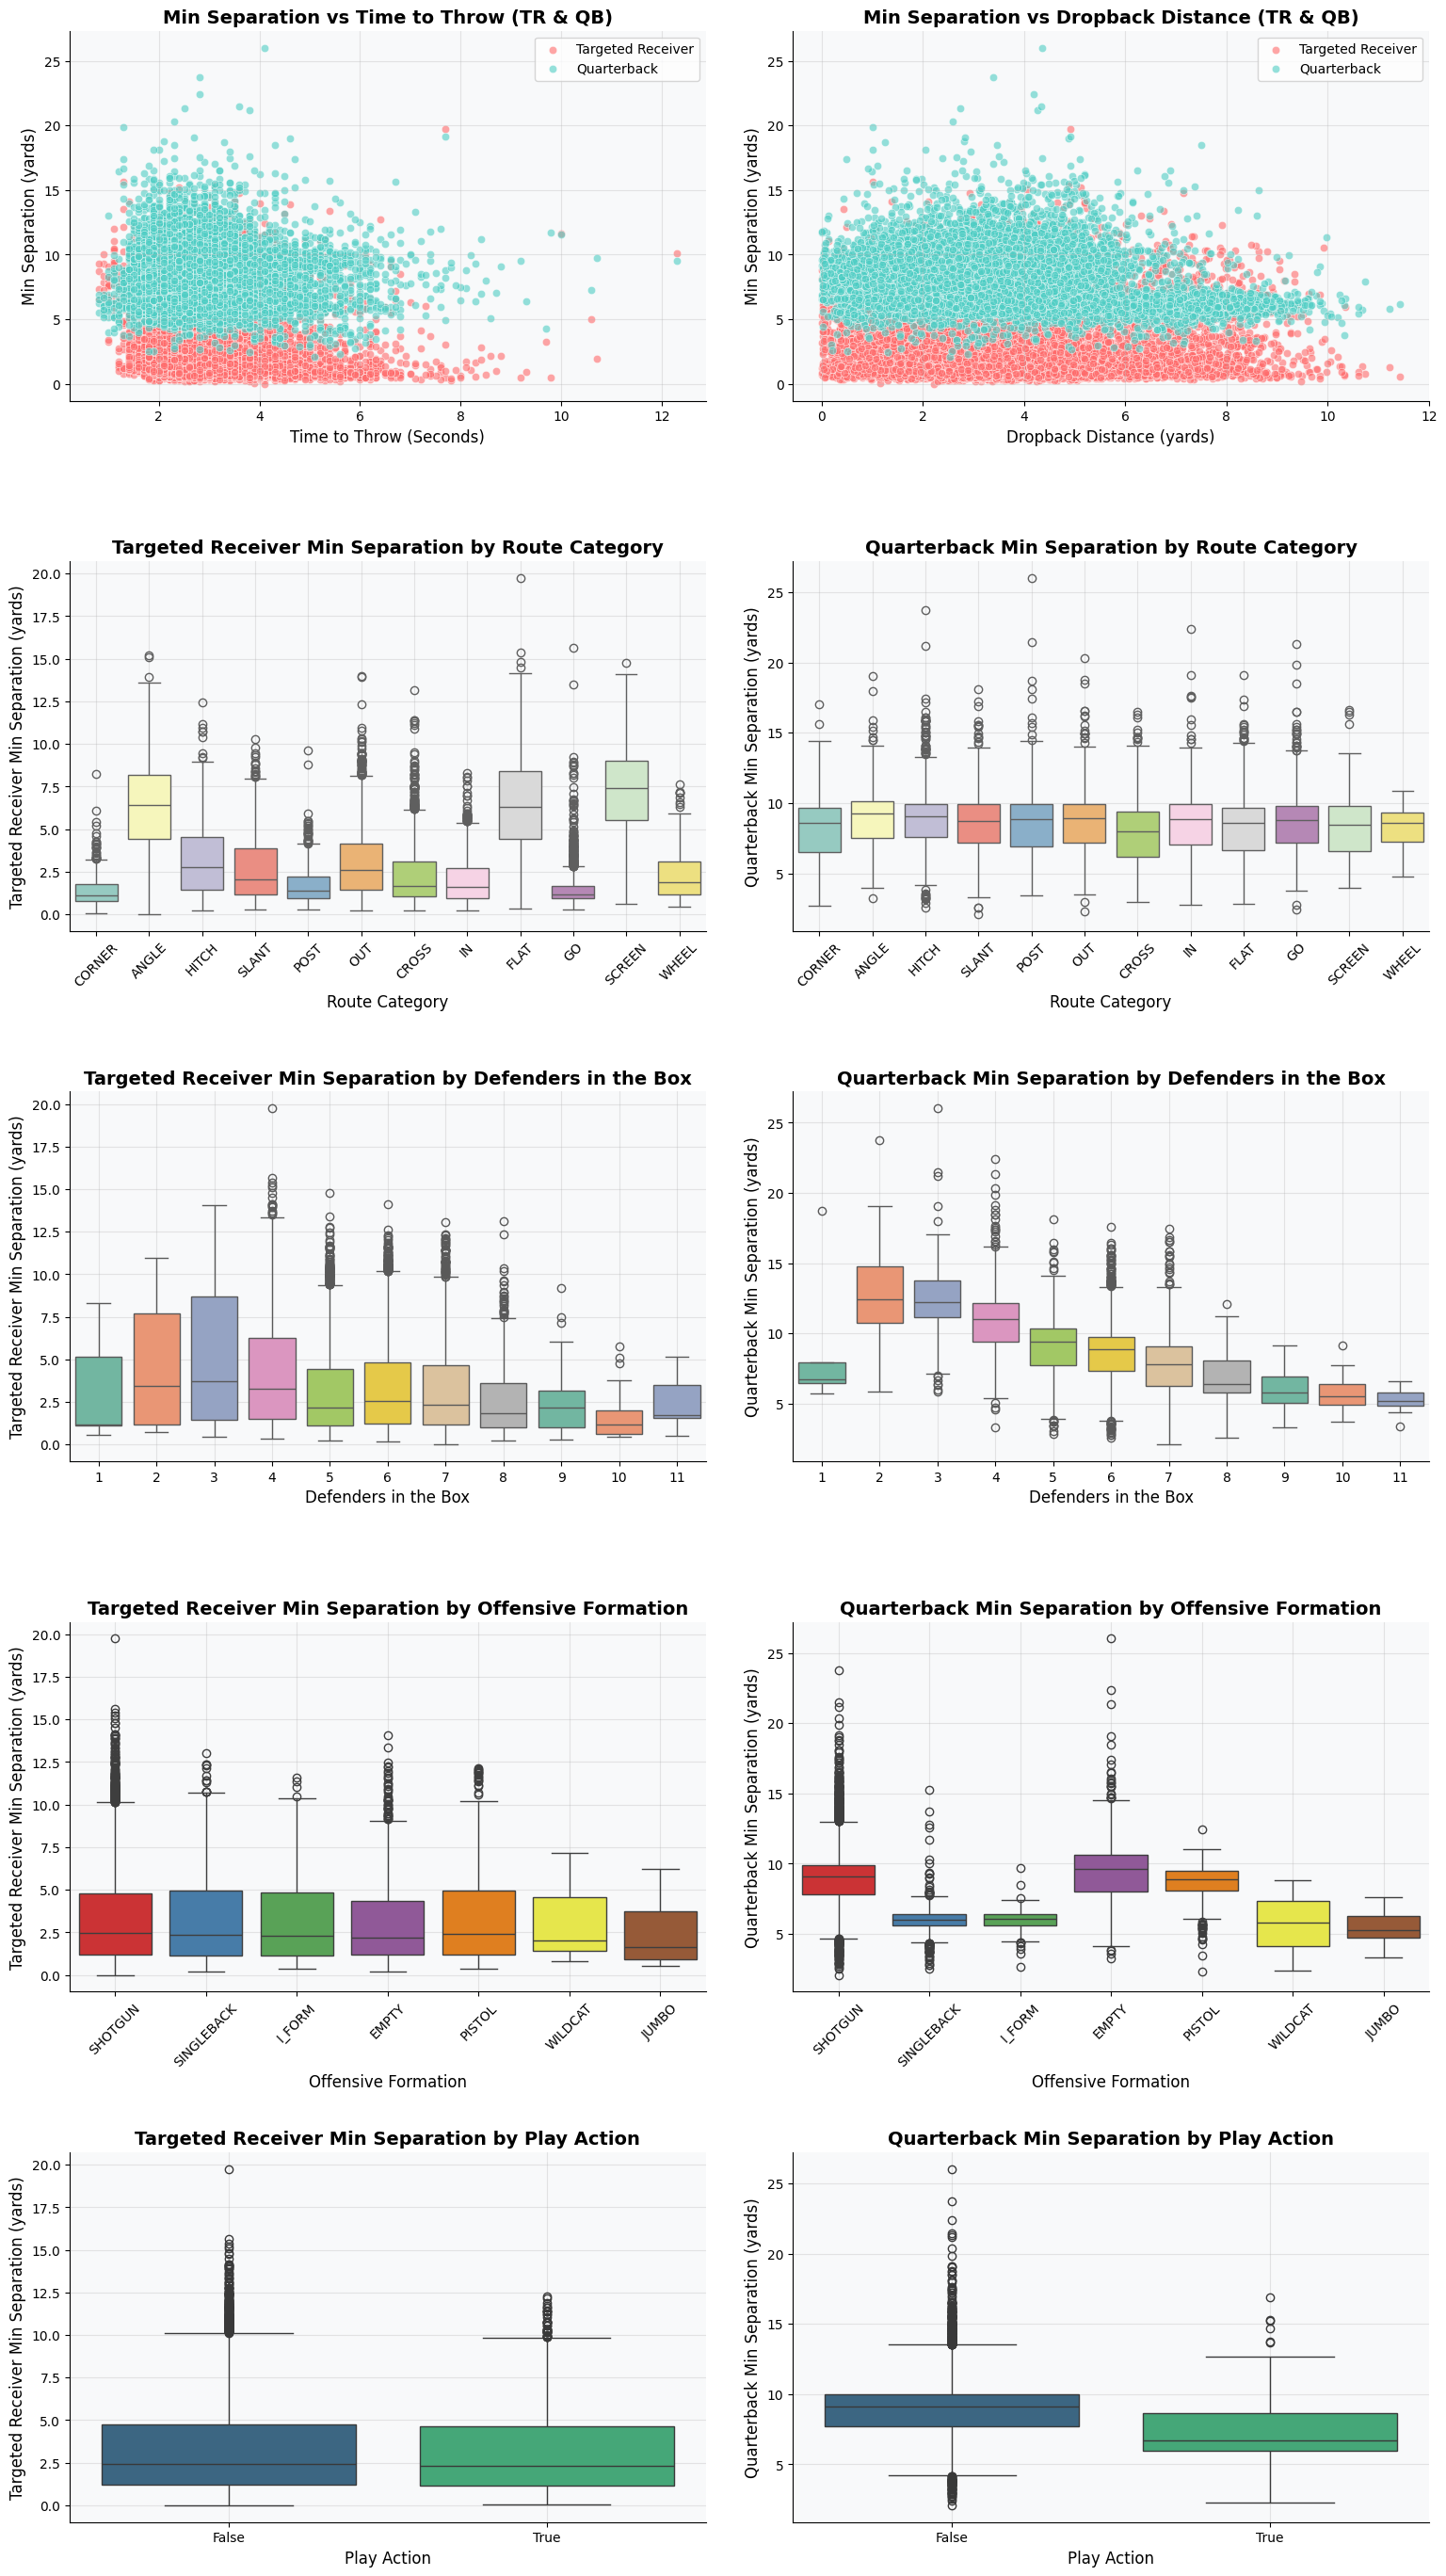

✓ All comparative visualizations completed successfully


<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualization of play-level min seperation of Targeted Receivers and Quaterbacks with other variables to see trends
print(f"\n{'='*70}")
print("STEP 7: COMPARATIVE VISUALIZATIONS FOR TARGETED RECEIVERS AND QUARTERBACKS")
print("="*70)

import seaborn as sns
    
fig, axes = plt.subplots(5, 2, figsize=(16, 28))

# Scatter plot: Both TR and QB min separation vs Time to Throw
sns.scatterplot(data=merged_data, x='time_to_throw', y='tr_play_min_separation', ax=axes[0,0], color='#FF6B6B', alpha=0.6, label='Targeted Receiver')
sns.scatterplot(data=merged_data, x='time_to_throw', y='qb_play_min_separation', ax=axes[0,0], color='#4ECDC4', alpha=0.6, label='Quarterback')
axes[0,0].set_title('Min Separation vs Time to Throw (TR & QB)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Time to Throw (Seconds)', fontsize=12) 
axes[0,0].set_ylabel('Min Separation (yards)', fontsize=12)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Scatter plot:  Both TR and QB min separation vs Dropback Distance
sns.scatterplot(data=merged_data, x='dropback_distance', y='tr_play_min_separation', ax=axes[0,1], color='#FF6B6B', alpha=0.6, label='Targeted Receiver')
sns.scatterplot(data=merged_data, x='dropback_distance', y='qb_play_min_separation', ax=axes[0,1], color='#4ECDC4', alpha=0.6, label='Quarterback')
axes[0,1].set_title('Min Separation vs Dropback Distance (TR & QB)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Dropback Distance (yards)', fontsize=12)      
axes[0,1].set_ylabel('Min Separation (yards)', fontsize=12)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# Box plots: Targeted Receiver min separation vs Route Category
sns.boxplot(data=merged_data, x='route_of_targeted_receiver', y='tr_play_min_separation', ax=axes[1,0], palette='Set3')
axes[1,0].set_title('Targeted Receiver Min Separation by Route Category', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Route Category', fontsize=12) 
axes[1,0].set_ylabel('Targeted Receiver Min Separation (yards)', fontsize=12)   
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Box plots: QB min separation vs route Category
sns.boxplot(data=merged_data, x='route_of_targeted_receiver', y='qb_play_min_separation', ax=axes[1,1], palette='Set3')
axes[1,1].set_title('Quarterback Min Separation by Route Category', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Route Category', fontsize=12) 
axes[1,1].set_ylabel('Quarterback Min Separation (yards)', fontsize=12)   
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3) 

# Box plots: Targeted Receiver min separation vs defenders_in_the_box
sns.boxplot(data=merged_data, x='defenders_in_the_box', y='tr_play_min_separation', ax=axes[2,0], palette='Set2')
axes[2,0].set_title('Targeted Receiver Min Separation by Defenders in the Box', fontsize=14, fontweight='bold')
axes[2,0].set_xlabel('Defenders in the Box', fontsize=12)   
axes[2,0].set_ylabel('Targeted Receiver Min Separation (yards)', fontsize=12)
axes[2,0].grid(True, alpha=0.3) 

# Box plots: QB min separation vs defenders_in_the_box  
sns.boxplot(data=merged_data, x='defenders_in_the_box', y='qb_play_min_separation', ax=axes[2,1], palette='Set2')
axes[2,1].set_title('Quarterback Min Separation by Defenders in the Box', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Defenders in the Box', fontsize=12)
axes[2,1].set_ylabel('Quarterback Min Separation (yards)', fontsize=12)
axes[2,1].grid(True, alpha=0.3) 

# Box plots: Targeted Receiver min separation vs offense_formation
sns.boxplot(data=merged_data, x='offense_formation', y='tr_play_min_separation', ax=axes[3,0], palette='Set1')
axes[3,0].set_title('Targeted Receiver Min Separation by Offensive Formation', fontsize=14, fontweight='bold')
axes[3,0].set_xlabel('Offensive Formation', fontsize=12)
axes[3,0].set_ylabel('Targeted Receiver Min Separation (yards)', fontsize=12)
axes[3,0].tick_params(axis='x', rotation=45)
axes[3,0].grid(True, alpha=0.3)     
# Box plots: QB min separation vs offense_formation
sns.boxplot(data=merged_data, x='offense_formation', y='qb_play_min_separation', ax=axes[3,1], palette='Set1')
axes[3,1].set_title('Quarterback Min Separation by Offensive Formation', fontsize=14, fontweight='bold')
axes[3,1].set_xlabel('Offensive Formation', fontsize=12)        
axes[3,1].set_ylabel('Quarterback Min Separation (yards)', fontsize=12)
axes[3,1].tick_params(axis='x', rotation=45)
axes[3,1].grid(True, alpha=0.3)

# Box plots: Targeted Receiver min separation vs play_action
sns.boxplot(data=merged_data, x='play_action', y='tr_play_min_separation', ax=axes[4,0], palette='viridis')
axes[4,0].set_title('Targeted Receiver Min Separation by Play Action', fontsize=14, fontweight='bold')
axes[4,0].set_xlabel('Play Action', fontsize=12)
axes[4,0].set_ylabel('Targeted Receiver Min Separation (yards)', fontsize=12)
axes[4,0].grid(True, alpha=0.3)

# Box plots: QB min separation vs play_action
sns.boxplot(data=merged_data, x='play_action', y='qb_play_min_separation', ax=axes[4,1], palette='viridis')
axes[4,1].set_title('Quarterback Min Separation by Play Action', fontsize=14, fontweight='bold')
axes[4,1].set_xlabel('Play Action', fontsize=12)
axes[4,1].set_ylabel('Quarterback Min Separation (yards)', fontsize=12)
axes[4,1].grid(True, alpha=0.3)

# Apply consistent styling to all subplots
for ax in axes.flat:
    ax.set_facecolor('#f8f9fa')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()
# plt.close()  # Properly close figure

print("✓ All comparative visualizations completed successfully")


TESTING TEMPORAL SEPARATION FUNCTION
Found 39638 'GO' route records
Selected 10 plays with 386 total records


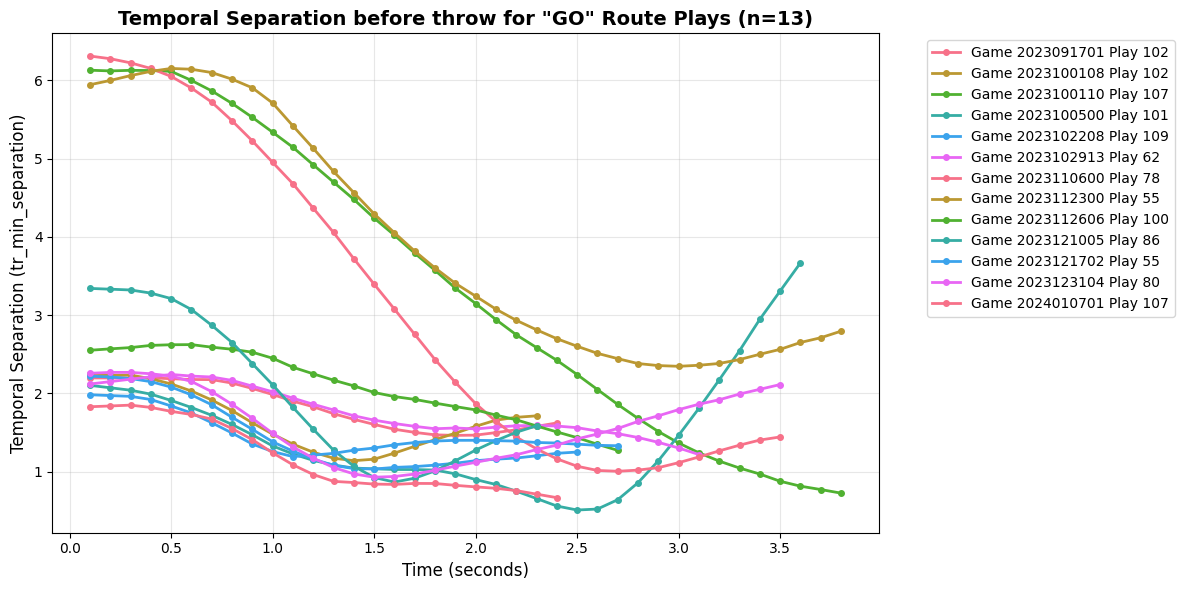

Found 55688 'FLAT' route records
Selected 10 plays with 771 total records


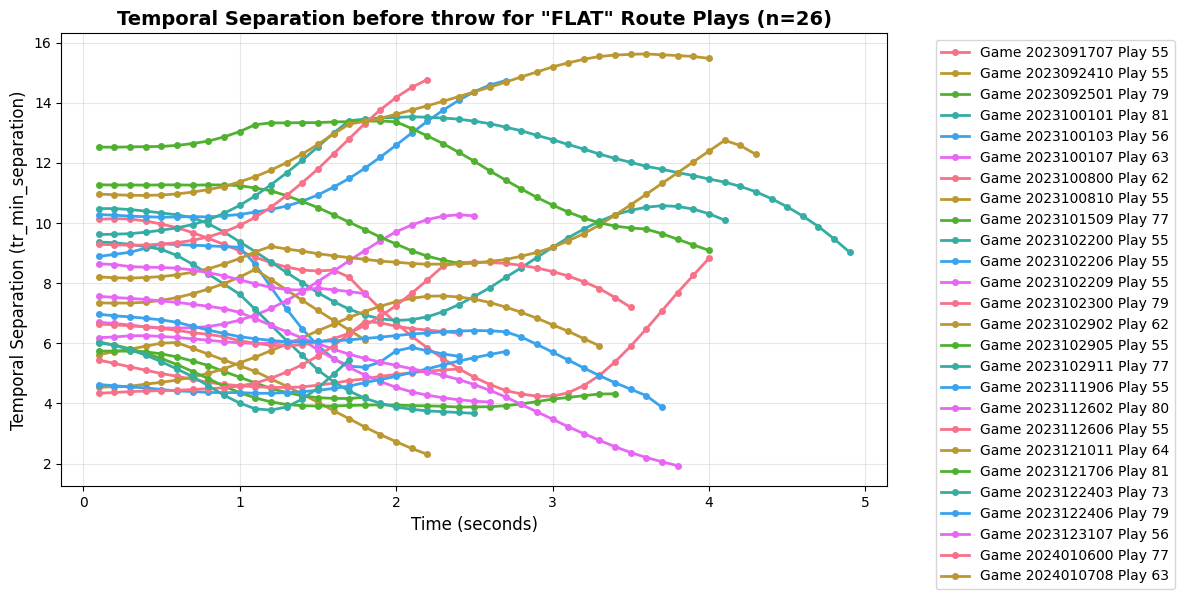

Found 7774 'SCREEN' route records
Selected 10 plays with 229 total records


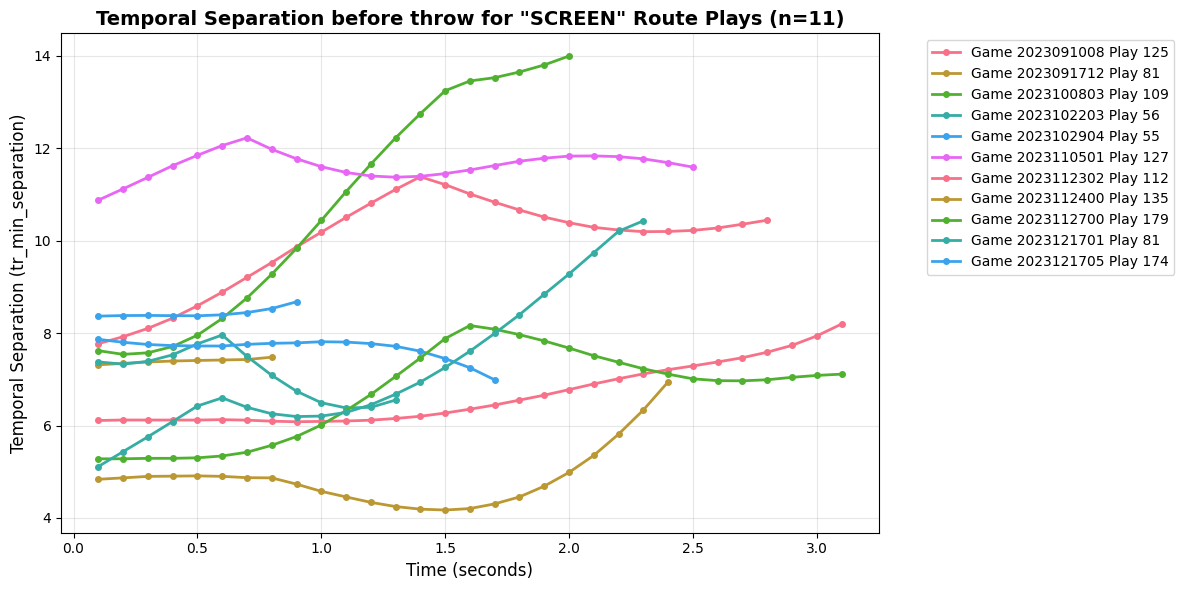


Testing with 'ANGLE' route:
Found 17091 'ANGLE' route records
Selected 10 plays with 421 total records


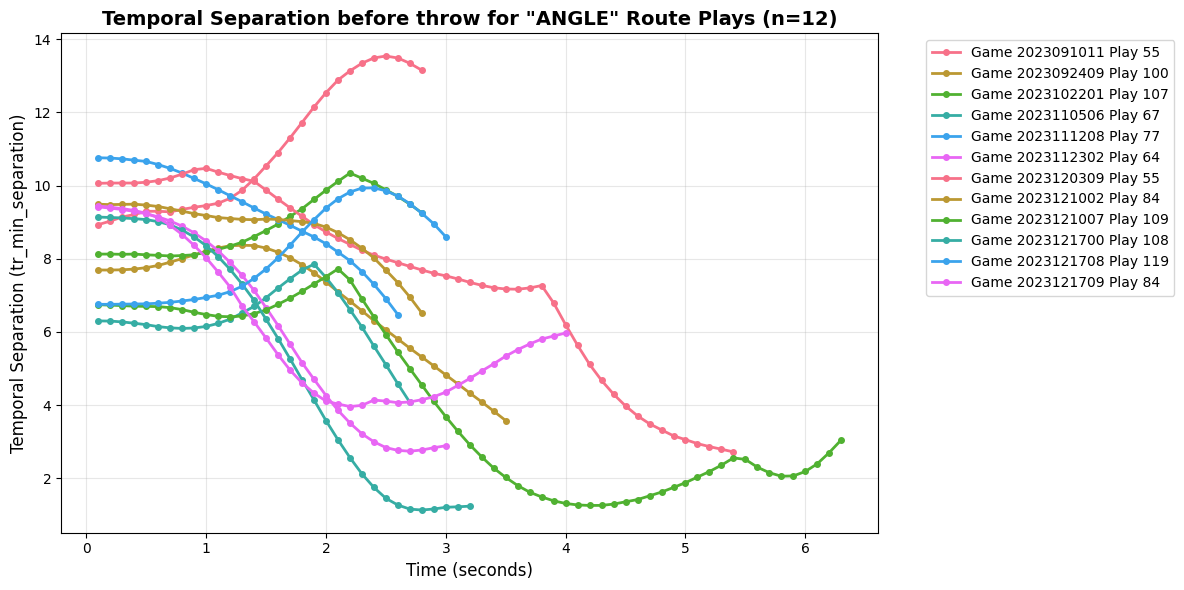

In [17]:
def plot_temporal_separation_by_route(df, route_name, max_plays=10):
    """
    Plot temporal separation for plays of a specific route type.
    
    Parameters:
    df: DataFrame with separation data containing columns:
        - route_of_targeted_receiver, play_id, game_id, frame_id, tr_min_separation
    route_name: String name of the route to filter for (e.g., 'Go', 'Slant', 'Out')
    max_plays: Maximum number of plays to display (default 10)
    
    Returns:
    None (displays plot)
    """
    # Filter for route plays and get first 10 unique plays with all their frames
    route_data = df[df['route_of_targeted_receiver'] == route_name].copy()

    
    print(f"Found {len(route_data)} '{route_name}' route records")
    
    # Get first 10 unique plays
    unique_plays = sorted(route_data['play_id'].unique())[:10]
    route_data = route_data[route_data['play_id'].isin(unique_plays)]
    
    print(f"Selected {len(unique_plays)} plays with {len(route_data)} total records")
    
    # Sort by time for proper line plotting
    route_data = route_data.sort_values(['game_id', 'play_id', 'frame_id'])
    
    # Plot temporal separation for route route plays
    plt.figure(figsize=(12, 6))   

    plot_count = 0
    for (game_id, play_id), play_group in route_data.groupby(['game_id', 'play_id']):
        if not play_group.empty:
            plt.plot(play_group['frame_id'] * 0.1, play_group['tr_min_separation'], 
                    marker='o', linestyle='-', linewidth=2, markersize=4,
                    label=f'Game {game_id} Play {play_id}')
            plot_count += 1

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Temporal Separation (tr_min_separation)', fontsize=12)
    plt.title(f'Temporal Separation before throw for "{route_name}" Route Plays (n={plot_count})', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()   


# Example usage of the new function
print(f"\n{'='*70}")
print("TESTING TEMPORAL SEPARATION FUNCTION")
print("="*70)

# Test route
plot_temporal_separation_by_route(tr_separation_df, 'GO', max_plays=10)
plot_temporal_separation_by_route(tr_separation_df, 'FLAT', max_plays=10)
plot_temporal_separation_by_route(tr_separation_df, 'SCREEN', max_plays=10)

# Test with another route if available
available_routes = tr_separation_df['route_of_targeted_receiver'].dropna().unique()
if len(available_routes) > 1:
    second_route = available_routes[1]
    print(f"\nTesting with '{second_route}' route:")
    plot_temporal_separation_by_route(tr_separation_df, second_route, max_plays=5)